In [ ]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')
API_KEY = userdata.get('API_KEY')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fredapi
!pip install joblib

In [ ]:
!pip install catboost

In [ ]:
import fredapi as fa
import pandas as pd
import numpy as np
import warnings
import time
import pickle
import joblib
import os
from sklearn.metrics import (classification_report, confusion_matrix,
brier_score_loss, roc_auc_score, precision_recall_fscore_support, recall_score, make_scorer, precision_score, precision_recall_curve, PrecisionRecallDisplay, f1_score, average_precision_score)
import sklearn.model_selection as skm
from sklearn.decomposition import PCA, FactorAnalysis, SparsePCA
from statsmodels.multivariate.pca import PCA as smPCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import (DecisionTreeClassifier as DTC, plot_tree, export_text)
from sklearn.metrics import (accuracy_score)
from sklearn.svm import SVC
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
import shap
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import randint, uniform
warnings.filterwarnings('ignore')

# Data Setup
### Loading

In [ ]:
all_vars_raw = pd.read_csv('/content/drive/MyDrive/Diffusion Indices/2025-04-MD.csv')
all_vars_raw

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.00,6.00,6.0000,1.0000
1,1/1/1959,2583.560,2426.0,15.188,2.766768e+05,17689.23968,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,2.787140e+05,17819.01912,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,2.777753e+05,17967.91336,22.7142,23.8459,22.5651,31.8987,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,2.833627e+05,17978.97983,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,11/1/2024,20091.169,16376.8,122.396,1.545040e+06,712145.00000,101.9619,99.3808,98.8609,100.8691,...,119.230,129.380,31.59,36.26,28.22,71.8,556011.41,938335.20,5381.4576,15.9822
792,12/1/2024,20101.629,16387.7,123.077,1.558008e+06,717662.00000,103.1177,100.4976,99.9719,101.6868,...,119.746,129.875,31.72,36.43,28.33,74.0,559364.75,943484.76,5366.6686,15.6997
793,1/1/2025,20148.969,16391.2,122.614,1.543178e+06,711461.00000,103.3418,101.0766,100.6319,102.1879,...,120.457,130.281,31.91,36.56,28.58,71.7,559087.09,944167.06,5350.2541,16.8122
794,2/1/2025,20209.351,16389.5,122.742,1.556553e+06,711680.00000,104.2202,101.8233,101.4377,102.7245,...,120.615,130.990,32.00,36.66,28.68,64.7,556142.06,941199.49,5367.9408,17.0705


In [ ]:
# Extracting transformation codes
tcodes = all_vars_raw.iloc[0].copy()
tcodes = tcodes.drop('sasdate')

In [ ]:
all_vars_data = all_vars_raw.drop(0).reset_index(drop=True)

In [ ]:
# Set index and convert to datetime
all_vars_data = all_vars_data.set_index('sasdate')
all_vars_data.index = pd.to_datetime(all_vars_data.index)
all_vars_data.index.name = 'Date'

In [ ]:
data_cols = all_vars_data.columns
for col in data_cols:
  all_vars_data[col] = pd.to_numeric(all_vars_data[col], errors='coerce')

In [ ]:
all_vars_data = all_vars_data['1959-01-01':'2025-03-01']

In [ ]:
X_transformed = pd.DataFrame(index=all_vars_data.index)
nan_counts_per_transform = {1: 0, 2: 1, 3: 2, 4: 0, 5: 1, 6: 2, 7: 12}
max_transform_nan = 0

In [ ]:
# Removing problematic variables
vars_to_remove = ['ACOGNO', 'TWEXAFEGSMTHx', 'OILPRICEx', 'UMCSENTx', 'ANDENOx']

# Remove them from the main data DataFrame AND the tcodes Series
original_cols = list(all_vars_data.columns)
removed_count = 0
for var in vars_to_remove:
    if var in all_vars_data.columns:
        all_vars_data = all_vars_data.drop(columns=[var])
        if var in tcodes.index:
            tcodes = tcodes.drop(var)
        print(f"Removed problematic variable: {var}")
        removed_count += 1
    else:
        print(f"Warning: Variable {var} listed for removal not found in DataFrame.")

print(f"Removed {removed_count} variables based on McCracken & Ng (2016) recommendations.")
print(f"Shape after removal: {all_vars_data.shape}")

# Update data_cols list if you use it later
data_cols = all_vars_data.columns

Removed problematic variable: ACOGNO
Removed problematic variable: TWEXAFEGSMTHx
Removed problematic variable: OILPRICEx
Removed problematic variable: UMCSENTx
Removed problematic variable: ANDENOx
Removed 5 variables based on McCracken & Ng (2016) recommendations.
Shape after removal: (795, 121)


### Transforming

In [ ]:
for col in data_cols:
  series = all_vars_data[col]
  code = int(tcodes[col])
  current_max_nan = nan_counts_per_transform[code]
  max_transform_nan = max(max_transform_nan, current_max_nan)

  if code == 1:
    transformed_series = series
  elif code == 2:
    transformed_series = series.diff(1)
  elif code == 3:
    transformed_series = series.diff(1).diff(1)
  elif code == 4:
    transformed_series = np.log(series.clip(lower=1e-10))
    if (series <= 0).any():
      print(f"Column {col} has negatives, logs will cause NaNs")
  elif code == 5:
    series_clipped = series.clip(lower=1e-10)
    transformed_series = np.log(series_clipped).diff(1)
    if (series <= 0).any():
      print(f"Column {col} (Code 5) has non-positive values. Log difference applied, NaNs expected")
  elif code == 6:
    series_clipped = series.clip(lower=1e-10)
    transformed_series = np.log(series_clipped).diff(1).diff(1)
    if (series <= 0).any():
      print(f"Column {col} (Code 5) has non-positive values. Log difference applied, NaNs expected")
  elif code == 7:
    denominator = series.shift(12)
    denominator = denominator.replace(0, np.nan)
    denominator[denominator.abs() < 1e-10] = np.nan
    transformed_series = ((series / denominator) - 1)
  else:
    print(f"Unexpected code {code} for {col}, keeping original")
    transformed_series = series

  X_transformed[col] = transformed_series

print(f"Transformations applied, max NaNs introduced by a single transform: {max_transform_nan}")
print("\nTransformed Data Head (showing initial NaNs):")
print(X_transformed.head(max(15, max_transform_nan + 2))) # Show enough rows to see initial NaNs
print("\nNaN count per column after transformations (Top 20):")
print(X_transformed.isna().sum().sort_values(ascending=False).head(20))
print(f"\nTransformed data shape: {X_transformed.shape}")

Transformations applied, max NaNs introduced by a single transform: 12

Transformed Data Head (showing initial NaNs):
                 RPI   W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx  \
Date                                                                   
1959-01-01       NaN       NaN              NaN        NaN       NaN   
1959-02-01  0.003877  0.003621         0.010349   0.007336  0.007310   
1959-03-01  0.006457  0.007325         0.009404  -0.003374  0.008321   
1959-04-01  0.006510  0.007029        -0.003622   0.019915  0.000616   
1959-05-01  0.005796  0.006618         0.012043   0.006839  0.007803   
1959-06-01  0.003068  0.003012         0.003642  -0.000097  0.009064   
1959-07-01 -0.000580 -0.000762        -0.003386   0.012155 -0.000330   
1959-08-01 -0.005653 -0.005755         0.005998  -0.052521  0.006364   
1959-09-01  0.000763  0.000000         0.010001   0.014660 -0.013157   
1959-10-01  0.001271  0.001170        -0.006825   0.001620  0.007288   
1959-11-01  0.0075

### Preparing Target

In [ ]:
fred = fa.Fred(api_key=API_KEY)
y_raw = fred.get_series('USRECM', observation_start='1959-01-01', observation_end='2025-03-01')
print(len(y_raw))

795


In [ ]:
# Shift target
prediction_horizon = 6
y_shifted = y_raw.shift(-prediction_horizon).rename('Target')
print(y_shifted.tail(prediction_horizon+5))

2024-05-01    0.0
2024-06-01    0.0
2024-07-01    0.0
2024-08-01    0.0
2024-09-01    0.0
2024-10-01    NaN
2024-11-01    NaN
2024-12-01    NaN
2025-01-01    NaN
2025-02-01    NaN
2025-03-01    NaN
Name: Target, dtype: float64


### Determining Analysis Window

In [ ]:
max_lag_later = 12
total_initial_drop = max_transform_nan + max_lag_later
first_usable_idx_pos = total_initial_drop
first_usable_date = X_transformed.index[first_usable_idx_pos]
last_usable_date = y_shifted.last_valid_index()
print(f"\n--> Analysis Window START: {first_usable_date.strftime('%Y-%m-%d')}")
print(f"--> Analysis Window END:   {last_usable_date.strftime('%Y-%m-%d')}")


--> Analysis Window START: 1961-01-01
--> Analysis Window END:   2024-09-01


In [ ]:
# After last_usable_date = y_shifted.last_valid_index() in Cell 75
print(f"DEBUG: last_valid_index() from y_shifted used for last_usable_date: {last_usable_date}")
print(f"DEBUG: Expected end based on data end and horizon: {pd.to_datetime('2024-12-01') - pd.DateOffset(months=prediction_horizon)}")

DEBUG: last_valid_index() from y_shifted used for last_usable_date: 2024-09-01 00:00:00
DEBUG: Expected end based on data end and horizon: 2024-06-01 00:00:00


In [ ]:
# Run this AFTER Cell 74 (where y_shifted is created)
print(f"Last valid index calculated from y_shifted: {y_shifted.last_valid_index()}")
print(f"Last date expected from y_raw: {last_usable_date}") # last_valid_date used for y_raw fetch
# Expected last_usable_date is 6 months before last_valid_date
expected_last_usable = pd.to_datetime(last_usable_date) - pd.DateOffset(months=prediction_horizon)
print(f"Expected last usable date based on horizon: {expected_last_usable}")

Last valid index calculated from y_shifted: 2024-09-01 00:00:00
Last date expected from y_raw: 2024-09-01 00:00:00
Expected last usable date based on horizon: 2024-03-01 00:00:00


In [ ]:
X_transformed_core = X_transformed.loc[first_usable_date:last_usable_date].copy()
print(f"Shape of full set base: {X_transformed_core.shape}")

Shape of full set base: (765, 121)


In [ ]:
# Prepare final target variable for the window
y_final = y_shifted.loc[first_usable_date:last_usable_date].copy()
print(f"Shape of final target: {y_final.shape}")
y_final

Shape of final target: (765,)


,Target
1961-01-01,0.0
1961-02-01,0.0
1961-03-01,0.0
1961-04-01,0.0
1961-05-01,0.0
...,...
2024-05-01,0.0
2024-06-01,0.0
2024-07-01,0.0
2024-08-01,0.0


### Preprocessing Validation

In [ ]:
assert len(y_final) == len(X_transformed_core), "ERROR: Length mismatch between target and features."

In [ ]:
print(f"NaNs in X_transformed_core: {X_transformed_core.isna().sum().sum()}")

NaNs in X_transformed_core: 21


In [ ]:
X_transformed_core.isna().sum().sort_values(ascending=False)

,0
VIXCLSx,18
CP3Mx,2
COMPAPFFx,1
W875RX1,0
RETAILx,0
...,...
CES0600000008,0
CES3000000008,0
DTCOLNVHFNM,0
DTCTHFNM,0


Code to check if transformation caused NAs even in the core window

In [ ]:
# col_to_check = 'COMPAPFFx'
# print(f"Transformation code for {col_to_check}: {tcodes.get(col_to_check)}")

# # Compare original vs transformed WITHIN the core window
# print("\nOriginal Data in Core Window (Head & Tail):")
# print(all_vars_data.loc[first_usable_date:last_usable_date, col_to_check].head(10))
# print(all_vars_data.loc[first_usable_date:last_usable_date, col_to_check].tail(10))
# print(f"Original NaN count in core window: {all_vars_data.loc[first_usable_date:last_usable_date, col_to_check].isna().sum()}")


# print(f"\nTransformed {col_to_check} in Core Window (Head & Tail):")
# print(X_transformed_core[col_to_check].head(15)) # Show more to see effect
# print(X_transformed_core[col_to_check].tail(15))
# print(f"Transformed NaN count in core window: {X_transformed_core[col_to_check].isna().sum()}")

# # If differencing, check for consecutive identical values in original
# if tcodes.get(col_to_check) in [2, 3, 5, 6]:
#      print("\nChecking for consecutive duplicates in original data within core window + lookback:")
#      lookback = 2 if tcodes.get(col_to_check) in [3,6] else 1
#      orig_slice_with_lookback = all_vars_data.loc[:last_usable_date, col_to_check] # Look from start up to end of core
#      consecutive_duplicates = orig_slice_with_lookback[orig_slice_with_lookback == orig_slice_with_lookback.shift(1)]
#      print(consecutive_duplicates.tail(20)) # See if recent duplicates exist that affect the core window diff

# # If log, check for non-positive values
# if tcodes.get(col_to_check) in [4, 5, 6]:
#      print("\nChecking for non-positive values in original data within core window:")
#      print(all_vars_data.loc[first_usable_date:last_usable_date, col_to_check][all_vars_data.loc[first_usable_date:last_usable_date, col_to_check] <= 0])

#  # If YoY %, check denominator NaNs/Zeros
# if tcodes.get(col_to_check) == 7:
#     print("\nChecking for NaNs/Zeros in original data 12 months prior within core window:")
#     denominator_slice = all_vars_data[col_to_check].shift(12).loc[first_usable_date:last_usable_date]
#     print(denominator_slice[denominator_slice.isna() | (denominator_slice.abs() < 1e-9)].head(20)) # Check where denominator has issues

## Generating Predictor Set Building Blocks

### Generating Yield Curve

In [ ]:
spread_data = pd.read_csv('/content/drive/MyDrive/Diffusion Indices/yieldspread.csv')
spread_df = pd.DataFrame({'Date': spread_data['Date'], 'Spread': spread_data['Spread']})
spread_df_og = spread_df.set_index('Date')
spread_df = spread_df_og.loc['31-Jan-59':'30-Jun-17']
spread_df['Spread']
spread_index = spread_df.index
date_index = []
for date in spread_index:
    datetime = pd.to_datetime(date, format='%d-%b-%y')
    if datetime.year >= 2059:
        datetime = datetime.replace(year=datetime.year-100)
    date_index.append(datetime)
print(len(date_index))
spread_df = pd.DataFrame({'Date': date_index, 'Spread': spread_df['Spread']})
spread_df_1 = spread_df.set_index('Date')
spread_df_2 = spread_df_og.loc['7/31/2017':'12/31/2024']
spread_index_2 = spread_df_2.index
date_index_2 = []
for date in spread_index_2:
    datetime = pd.to_datetime(date)
    if datetime.year >= 2059:
        datetime = datetime.replace(year=datetime.year-100)
    date_index_2.append(datetime)
print(len(date_index))
spread_df = pd.DataFrame({'Date': date_index_2, 'Spread': spread_df_2['Spread']})
spread_df_2 = spread_df.set_index('Date')
X_raw_spread = pd.concat([spread_df_1, spread_df_2])
X_raw_spread = X_raw_spread.resample('MS').mean()
X_raw_spread = X_raw_spread.loc[first_usable_date:last_usable_date]
X_raw_spread

702
702


,Spread
Date,
1961-01-01,1.56
1961-02-01,1.31
1961-03-01,1.30
1961-04-01,1.44
1961-05-01,1.37
...,...
2024-05-01,-0.91
2024-06-01,-1.07
2024-07-01,-1.09


### Generating Factor Set

In [ ]:
imputer_pca = KNNImputer(n_neighbors=5)
X_filled_for_pca = pd.DataFrame(imputer_pca.fit_transform(X_transformed_core),
                                index=X_transformed_core.index,
                                columns=X_transformed_core.columns)
scaler_sm_pca = StandardScaler()
X_scaled_for_sm_pca = scaler_sm_pca.fit_transform(X_filled_for_pca)


max_potential_factors = 50
print(f" Running statsmodels PCA considering up to {max_potential_factors} components...")
sm_pca_results = smPCA(X_scaled_for_sm_pca,
                       ncomp=max_potential_factors,
                       standardize=False, # Data is already scaled
                       demean=True)

print(" Calculating Bai & Ng Information Criteria...")
ic_values_array = sm_pca_results.ic


ICs_df = pd.DataFrame(ic_values_array,
                      index=np.arange(0, max_potential_factors+1), # Index k = 1, 2, ...
                      columns=['IC_p1', 'IC_p2', 'IC_p3']) # Name the columns


print(" Information Criteria DataFrame (IC_p1, IC_p2, IC_p3) Head:")
print(ICs_df.head())

try:
    optimal_k_ic2 = ICs_df['IC_p2'].idxmin() # Now works on the DataFrame
    min_ic2_value = ICs_df['IC_p2'].min()
    print(f"\n Optimal number of factors according to Bai & Ng IC_p2: {optimal_k_ic2}")
    print(f"    (Minimum IC_p2 value: {min_ic2_value:.4f})")

    # Optionally find for others
    optimal_k_ic1 = ICs_df['IC_p1'].idxmin()
    optimal_k_ic3 = ICs_df['IC_p3'].idxmin()
    print(f"    (Optimal for IC_p1: {optimal_k_ic1}, IC_p3: {optimal_k_ic3})")

except Exception as e:
    print(f" ERROR finding optimal k from ICs: {e}")
    print("  ICs DataFrame:")
    print(ICs_df) # Print the DataFrame for debugging
    optimal_k_ic2 = 8 # Default if fails
    print(f"  Defaulting to {optimal_k_ic2} factors.")


final_n_factors = optimal_k_ic2
all_eigenvals = sm_pca_results.eigenvals
if isinstance(all_eigenvals, np.ndarray): # Ensure it's usable
  total_variance = all_eigenvals.sum()
  if total_variance > 1e-9:
    all_explained_variance_ratios = all_eigenvals / total_variance
    # Select the ratios ONLY for the 'final_n_factors' we chose
    explained_variance_ratios_final = all_explained_variance_ratios[:final_n_factors] # Get as numpy array
  else:
    print("ERROR: Total variance (sum of eigenvalues) is zero or negative.")
    explained_variance_ratios_final = np.array([np.nan]*final_n_factors) # Error case
else:
  print("ERROR: Could not extract eigenvalues as expected Series/Array.")
  explained_variance_ratios_final = np.array([np.nan]*final_n_factors) # Error case

print(f" Extracting the top {final_n_factors} factors...")

factors_final_values = sm_pca_results.factors[:, :final_n_factors]

X_factors_raw_final = pd.DataFrame(factors_final_values,
                                   index=X_filled_for_pca.index,
                                   columns=[f'Factor_{i+1}' for i in range(final_n_factors)])

print("\n Final Factor DataFrame head (using Bai & Ng factors):")
print(X_factors_raw_final.head())
print(f"\n Final Factor DF shape: {X_factors_raw_final.shape}")
print(f" Final Factor DF NaNs: {X_factors_raw_final.isna().sum().sum()}")
print("\n--- End of Factor Generation using Bai & Ng Criteria ---")

 Running statsmodels PCA considering up to 50 components...
 Calculating Bai & Ng Information Criteria...
 Information Criteria DataFrame (IC_p1, IC_p2, IC_p3) Head:
       IC_p1      IC_p2      IC_p3
0  11.435666  11.435666  11.435666
1  11.263452  11.264858  11.258589
2  11.208322  11.211133  11.198595
3  11.152950  11.157166  11.138359
4  11.108241  11.113863  11.088787

 Optimal number of factors according to Bai & Ng IC_p2: 8
    (Minimum IC_p2 value: 11.0435)
    (Optimal for IC_p1: 9, IC_p3: 50)
 Extracting the top 8 factors...

 Final Factor DataFrame head (using Bai & Ng factors):
            Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Factor_6  \
Date                                                                     
1961-01-01  0.013078  0.020166  0.042480 -0.014670  0.026307 -0.049661   
1961-02-01  0.018949  0.020867 -0.001431 -0.011311  0.004790 -0.058260   
1961-03-01 -0.008520  0.008984  0.037110 -0.002201  0.021143 -0.045252   
1961-04-01 -0.010558  0.012068  0

In [ ]:
print(explained_variance_ratios_final)

[0.21039765 0.08244777 0.07480166 0.06078296 0.05555053 0.03552527
 0.02777145 0.02725729]


### Constructing Category-Based Diffusion Index

In [ ]:
# Defining categories (given by McCracken and Ng (2015))
variable_groups = {
    'Output_Income': ['RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS'],
    'Labor_Market': ['HWI', 'HWIURATIO', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008'],
    'Housing': ['HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW'],
    'Consumption_Orders_Inventories': ['DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx'],
    'Money_Credit': ['M1SL', 'M2SL', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST'],
    'Interest_Rates_Spreads': ['FEDFUNDS', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM'],
    'FX_Rates': ['EXSZUSx', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx'],
    'Prices': ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'],
    'Stock_Market': ['S&P 500', 'S&P div yield', 'S&P PE ratio', 'VIXCLSx']
}

# Other scenarios
counter_cyclical_vars = {
    'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV',
    'CLAIMSx', 'ISRATIOx'
}

level_log_positive_impact = {
    'CES0600000007', 'AWHMAN', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'T10YFFM'
}

level_log_negative_impact ={
    'VIXCLSx', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'AAAFFM', 'BAAFFM'
}
leading_indicators_group = {
    'Leading_Indicators': [
        'AWOTMAN',          # Avg Weekly Overtime Hours, Mfg (tcode 2, Pro-cyclical >0)
        'AWHMAN',           # Avg Weekly Hours, Mfg (tcode 1, level_pos: diff>0)
        'HOUST',            # Housing Starts (tcode 4, level_pos: diff>0)
        'PERMIT',           # Building Permits (tcode 4, level_pos: diff>0)
        'CLAIMSx',          # Initial Claims (tcode 5, counter: <0)
        'T10YFFM',          # 10-Year Treasury minus Fed Funds (tcode 1, level_pos: diff>0)
        'S&P 500',          # S&P 500 Index (tcode 5, Pro-cyclical >0)
        'AMDMNOx',          # New Orders, Durable Goods (tcode 5, Pro-cyclical >0) - *Check exact orders series used*
        # Add others like M2REAL (Money Supply) if desired and tcode allows >0 logic easily
        # Remove any from this list if not present in your final columns
     ]
}
# Threshold for small increase relative to standard deviation
small_change_threshold_fraction = 0.1

In [ ]:
diffusion_indices = {}
all_grouped_vars_found = set()
imputer_core = KNNImputer(n_neighbors=5)
X_imputed_core = pd.DataFrame(imputer_core.fit_transform(X_transformed_core),
                                  index=X_transformed_core.index,
                                  columns=X_transformed_core.columns)
# Calculate standard deviations for thresholding
std_devs = X_imputed_core.std()
small_change_thresholds = std_devs * small_change_threshold_fraction

for category_name, category_vars in variable_groups.items():
  valid_category_vars = [var for var in category_vars if var in X_imputed_core.columns]
  if not valid_category_vars:
    print(f'Skipping category {category_name}, no valid variables')
    continue

  all_grouped_vars_found.update(valid_category_vars)
  category_data = X_imputed_core[valid_category_vars]

  # Stores numerical state for category
  improvement_state_values = pd.DataFrame(index=category_data.index, dtype=float)

  for col_name in valid_category_vars:
    series = category_data[col_name]
    threshold = small_change_thresholds.get(col_name, 0)
    state_col = pd.Series(index=series.index, dtype=float)

    if col_name in level_log_positive_impact:
      diff_series = series.diff(1)
      state_col[diff_series > threshold] = 1.0 # Strong increase = good
      state_col[(diff_series > -threshold) & (diff_series <= threshold)] = 0.5 # Flat/Small Change = Mid
      state_col[diff_series <= -threshold] = 0.0 # Decrease = Bad
    elif col_name in level_log_negative_impact:
      diff_series = series.diff(1)
      state_col[diff_series < -threshold] = 1.0 # Strong Decrease = Good
      state_col[(diff_series >= -threshold) & (diff_series < threshold)] = 0.5 # Flat/Small Change = Mid
      state_col[diff_series >= threshold] = 0.0 # Increase = Bad
    elif col_name in counter_cyclical_vars:
      state_col[series < -threshold] = 1.0 # Strong Decrease = Good
      state_col[(series >= -threshold) & (series < threshold)] = 0.5 # Flat/Small Change = Mid
      state_col[series >= threshold] = 0.0 # Increase = Bad
    else:
      state_col[series > threshold] = 1.0 # Strong Increase = Good
      state_col[(series > -threshold) & (series <= threshold)] = 0.5 # Flat/Small Change = Mid
      state_col[series <= -threshold] = 0.0 # Decrease = Bad

    improvement_state_values[col_name] = state_col
  # Average state calculation
  di_series = improvement_state_values.mean(axis=1, skipna=True)
  diffusion_indices[category_name + '__DI'] = di_series
  print(f"Calculated diffusion index for {category_name} ({len(valid_category_vars)} variables)")

X_cbdi_raw = pd.DataFrame(diffusion_indices)

Calculated diffusion index for Output_Income (16 variables)
Calculated diffusion index for Labor_Market (31 variables)
Calculated diffusion index for Housing (10 variables)
Calculated diffusion index for Consumption_Orders_Inventories (7 variables)
Calculated diffusion index for Money_Credit (13 variables)
Calculated diffusion index for Interest_Rates_Spreads (17 variables)
Calculated diffusion index for FX_Rates (4 variables)
Calculated diffusion index for Prices (19 variables)
Calculated diffusion index for Stock_Market (4 variables)


In [ ]:
# Adding overall DI
overall_data = X_imputed_core[list(all_grouped_vars_found)]
overall_improvement_state_values = pd.DataFrame(index=overall_data.index, dtype=float)

for col_name in overall_data.columns:
    # Apply same logic as above to ALL variables used in groups
    series = overall_data[col_name]
    threshold = small_change_thresholds.get(col_name, 0)
    state_col = pd.Series(index=series.index, dtype=float)
    if col_name in level_log_positive_impact:
        diff_series = series.diff(1)
        state_col[diff_series > threshold] = 1.0
        state_col[(diff_series > -threshold) & (diff_series <= threshold)] = 0.5
        state_col[diff_series <= -threshold] = 0.0
    elif col_name in level_log_negative_impact:
        diff_series = series.diff(1);
        state_col[diff_series < -threshold] = 1.0
        state_col[(diff_series >= -threshold) & (diff_series < threshold)] = 0.5
        state_col[diff_series >= threshold] = 0.0
    elif col_name in counter_cyclical_vars:
        state_col[series < -threshold] = 1.0
        state_col[(series >= -threshold) & (series < threshold)] = 0.5
        state_col[series >= threshold] = 0.0
    else:
        state_col[series > threshold] = 1.0
        state_col[(series > -threshold) & (series <= threshold)] = 0.5
        state_col[series <= -threshold] = 0.0
    overall_improvement_state_values[col_name] = state_col

X_cbdi_raw['Overall_DI'] = overall_improvement_state_values.mean(axis=1, skipna=True)
print(X_cbdi_raw.head())
print(f"Total NaNs: {X_cbdi_raw.isna().sum().sum()}")


            Output_Income__DI  Labor_Market__DI  Housing__DI  \
Date                                                           
1961-01-01            0.68750          0.362069          NaN   
1961-02-01            0.46875          0.241935         0.60   
1961-03-01            0.71875          0.612903         0.75   
1961-04-01            0.96875          0.419355         0.25   
1961-05-01            0.96875          0.612903         0.75   

            Consumption_Orders_Inventories__DI  Money_Credit__DI  \
Date                                                               
1961-01-01                            0.214286          0.423077   
1961-02-01                            0.714286          0.423077   
1961-03-01                            0.642857          0.615385   
1961-04-01                            0.428571          0.576923   
1961-05-01                            1.000000          0.653846   

            Interest_Rates_Spreads__DI  FX_Rates__DI  Prices__DI  \
Date  

In [ ]:
if X_cbdi_raw.index[1:].equals(X_imputed_core.index[1:]):
     print("Index alignment verified (ignoring first row potentially affected by diff()).")
else:
     print("Index mismatch suspected")

X_cbdi_raw.to_pickle("X_cbdi_raw_3state.pkl")
print("3-State Category Diffusion Index DataFrame saved as X_cbdi_raw_3state.pkl")

Index alignment verified (ignoring first row potentially affected by diff()).
3-State Category Diffusion Index DataFrame saved as X_cbdi_raw_3state.pkl


### Building Factor-Based Diffusion Index

In [ ]:
print("--- Calculating Factor-Based Diffusion Indices (Method 1: Sign-Based Contribution) ---")

if isinstance(sm_pca_results.loadings, pd.DataFrame):
  loadings_df = sm_pca_results.loadings
  print("Loadings appear to be a DataFrame.")
elif isinstance(sm_pca_results.loadings, np.ndarray):
  print("Loadings are a NumPy array. Converting to DataFrame...")
  try:
      factor_columns_generated = [f'Factor_{i+1}' for i in range(sm_pca_results.loadings.shape[1])]
      variable_index = X_imputed_core.columns
      loadings_df = pd.DataFrame(sm_pca_results.loadings,
                                  index=variable_index,
                                  columns=factor_columns_generated)
      optimized_factors = X_factors_raw_final.columns
      loadings_df = loadings_df[optimized_factors]
      print("Conversion successful.")
  except Exception as e:
    print(f"ERROR converting loadings NumPy array to DataFrame: {e}")
    loadings_df = None # Indicate failure
else:
  print("ERROR: sm_pca_results.loadings is an unexpected type. Cannot proceed.")
  loadings_df = None

if loadings_df is None:
  print("Stopping FBDI calculation due to loading issues.")
  X_fbdi_raw_m1 = pd.DataFrame()
  nan_check = pd.Series()
else:
  available_factors = list(X_factors_raw_final.columns)
  factors_to_include = [f for f in ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4'] if f in available_factors]
  print(f" Factors used for FBDI calculation: {factors_to_include}")

  if not factors_to_include:
    print("ERROR: None of the specified factors found. Skipping FBDI.")
    X_fbdi_raw_m1 = pd.DataFrame()
    nan_check = pd.Series()
  else:
    fbdi_results = {} # Dictionary to store each factor's DI Series

for factor_to_analyze in factors_to_include:
  print(f"\n-- Calculating FBDI for: {factor_to_analyze} --")

  # Get the specific factor from factor dataframe
  target_factor_series = X_factors_raw_final[factor_to_analyze]
  print(f"  NaNs check in input {factor_to_analyze}: {target_factor_series.isna().sum()}")
  if target_factor_series.isna().any():
    print(f"  ERROR: Input factor series {factor_to_analyze} contains NaNs!")
    continue

  # Get the loadings
  if factor_to_analyze not in loadings_df.columns:
    print(f"  ERROR: Loadings column for {factor_to_analyze} not found. Skipping.")
    continue
  target_factor_loadings = loadings_df[factor_to_analyze] # This is a pandas Series (Var -> Loading)
  if target_factor_loadings.isna().any():
    print(f"  ERROR: Loadings for {factor_to_analyze} contain NaNs!")
    continue

  # Calculate Factor Difference
  factor_diff = target_factor_series.diff(1)
  print(f"  NaNs check in factor_diff (expect <= 1): {factor_diff.isna().sum()}")
  if factor_diff.iloc[1:].isna().any(): # Check if unexpected NaNs exist beyond the first one
    print(f"  WARN: Unexpected NaNs found in factor_diff beyond the first row!")

  # Calculate Absolute Loadings and Total for normalization
  absolute_loadings = target_factor_loadings.abs()

  variables_in_analysis = X_imputed_core.columns
  total_abs_loading = absolute_loadings.loc[variables_in_analysis].sum()
  print(f"  Total absolute loading for {factor_to_analyze} (across {len(variables_in_analysis)} vars): {total_abs_loading:.4f}")

  if pd.isna(total_abs_loading) or total_abs_loading < 1e-9:
    print(f"  ERROR: Total absolute loading is zero/NaN for {factor_to_analyze}. Skipping FBDI calculation.")
    fbdi_results[f'FBDI_Weighted_{factor_to_analyze}'] = pd.Series(np.nan, index=X_imputed_core.index)
    continue

  # Loop Through Variables and Accumulate Weighted States
  fbdi_contrib_weighted = pd.Series(0.0, index=factor_diff.index)

  for var_name in variables_in_analysis:
    loading = target_factor_loadings.get(var_name) # Get scalar loading
    abs_loading_val = absolute_loadings.get(var_name, 0) # Get scalar absolute loading

    if loading is None or pd.isna(loading) or abs_loading_val == 0:
      continue

    # Calculate approximate change contribution
    contribution_diff = loading * factor_diff

    # Get the threshold specific to this variable
    threshold = small_change_thresholds.get(var_name, 0)

    # Determine state (0, 0.5, 1) based on the factor's push
    state_col = pd.Series(0.5, index=contribution_diff.index, dtype=float) # Default neutral
    state_col[contribution_diff > threshold] = 1.0  # Strong Positive Push
    state_col[contribution_diff < -threshold] = 0.0 # Strong Negative Push
    # Fill initial NaN in diff with neutral state
    # (This should affect only the first row if factor_diff has only 1 NaN)
    state_col = state_col.fillna(0.5)

    # Accumulate state weighted by the absolute loading of the variable on this factor
    fbdi_contrib_weighted += state_col * abs_loading_val

  # Normalize
  fbdi_series_method1 = fbdi_contrib_weighted / total_abs_loading
  fbdi_results[f'FBDI_Weighted_{factor_to_analyze}'] = fbdi_series_method1
  print(f"  Finished calculating FBDI for {factor_to_analyze}.")

X_fbdi_raw_method1 = pd.DataFrame(fbdi_results)

print(f"\nFactor-Based Diffusion Index DataFrame (Method 1 - Factors {factors_to_include}) head(15):")
print(X_fbdi_raw_method1.head(15))
nan_check = X_fbdi_raw_method1.isna().sum()
print(f"NaN Check per column (expect <= 1 each):\n{nan_check}")
total_nans = nan_check.sum()
print(f"Total NaNs: {total_nans}")

if (nan_check <= 1).all():
  save_path = "X_fbdi_raw_method1.pkl" # Save locally in Colab session first
  try:
      X_fbdi_raw_method1.to_pickle(save_path)
      print(f"\nSaved: {save_path}")
  except Exception as e:
      print(f"\nERROR saving FBDI file: {e}")
else:
  print("\nERROR: Excessive NaNs (>1 per column) remain in FBDI Method 1. Not saved. Please debug.")

--- Calculating Factor-Based Diffusion Indices (Method 1: Sign-Based Contribution) ---
Loadings are a NumPy array. Converting to DataFrame...
Conversion successful.
 Factors used for FBDI calculation: ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4']

-- Calculating FBDI for: Factor_1 --
  NaNs check in input Factor_1: 0
  NaNs check in factor_diff (expect <= 1): 1
  Total absolute loading for Factor_1 (across 121 vars): 8.2735
  Finished calculating FBDI for Factor_1.

-- Calculating FBDI for: Factor_2 --
  NaNs check in input Factor_2: 0
  NaNs check in factor_diff (expect <= 1): 1
  Total absolute loading for Factor_2 (across 121 vars): 8.1727
  Finished calculating FBDI for Factor_2.

-- Calculating FBDI for: Factor_3 --
  NaNs check in input Factor_3: 0
  NaNs check in factor_diff (expect <= 1): 1
  Total absolute loading for Factor_3 (across 121 vars): 8.2543
  Finished calculating FBDI for Factor_3.

-- Calculating FBDI for: Factor_4 --
  NaNs check in input Factor_4: 0
  NaNs ch

In [ ]:
def analyze_factor_loadings(loadings_df, factor_name, top_n=15):
    """Prints variables with highest positive/negative absolute loadings for a factor."""
    if factor_name not in loadings_df.columns:
        print(f"Factor '{factor_name}' not found in loadings DataFrame.")
        return
    print(f"\\n--- Analyzing Loadings for: {factor_name} ---")

    # Get loadings for this factor
    factor_loadings = loadings_df[factor_name].copy()

    # Calculate absolute loadings and sort
    abs_loadings = factor_loadings.abs().sort_values(ascending=False)

    # Get top N variables by absolute loading
    top_vars = abs_loadings.head(top_n).index

    # Show actual loadings
    print(f"Top {top_n} variables by Absolute Loading on {factor_name}:")
    print(loadings_df.loc[top_vars, [factor_name]].sort_values(by=factor_name, ascending=False)) # Sort by signed loading

# Example: Analyze first 4 factors
if not loadings_df.empty:
    analyze_factor_loadings(loadings_df, 'Factor_1')
    analyze_factor_loadings(loadings_df, 'Factor_2')
    analyze_factor_loadings(loadings_df, 'Factor_3')
    analyze_factor_loadings(loadings_df, 'Factor_4')
else:
     print("Loadings DataFrame is empty, cannot analyze.")

\n--- Analyzing Loadings for: Factor_1 ---
Top 15 variables by Absolute Loading on Factor_1:
           Factor_1
UNRATE     0.173419
DMANEMP   -0.171813
IPBUSEQ   -0.174120
CE16OV    -0.174648
USTRADE   -0.174734
SRVPRD    -0.176802
IPFINAL   -0.176941
CUMFNS    -0.178865
USTPU     -0.179607
MANEMP    -0.180079
INDPRO    -0.182801
IPFPNSS   -0.183592
USGOOD    -0.185163
PAYEMS    -0.185948
IPMANSICS -0.187523
\n--- Analyzing Loadings for: Factor_2 ---
Top 15 variables by Absolute Loading on Factor_2:
                 Factor_2
CUSR0000SAC      0.224511
CUSR0000SA0L2    0.221779
CPIAUCSL         0.216639
CPITRNSL         0.215967
DNDGRG3M086SBEA  0.215130
CUSR0000SA0L5    0.212544
PCEPI            0.209745
CPIULFSL         0.203705
WPSFD49502       0.193451
WPSFD49207       0.188323
WPSID61          0.186182
PERMITW         -0.153338
PERMIT          -0.156998
HOUSTS          -0.158679
HOUST           -0.173678
\n--- Analyzing Loadings for: Factor_3 ---
Top 15 variables by Absolute Loadin

In [ ]:
print("\\n--- Calculating Recursive FBDI (NumPy Accumulation) ---")

RECURSION_START_DATE = '1961-01-01'
N_FACTORS_FIXED_REC = 8 # Keep reasonable number fixed
ALIGN_FACTOR = 'Factor_1'

X_for_recursion = X_imputed_core.loc[X_imputed_core.index.min():last_usable_date].copy()
dates_to_estimate = X_for_recursion.loc[RECURSION_START_DATE:].index
num_steps = len(dates_to_estimate)
first_window_sign_f1 = None

latest_factor_estimates_array = np.full((num_steps, N_FACTORS_FIXED_REC), np.nan)

scaler_rec = StandardScaler()
pca_rec = PCA(n_components=N_FACTORS_FIXED_REC, random_state=42)

start_time_rec_loop = time.time()
print(f"Starting recursive PCA loop from {RECURSION_START_DATE}...")

# Recursive Loop
for i, t in enumerate(dates_to_estimate): # Use enumerate to get index 'i' for array
  loop_step_start_rec = time.time()
  print(f" Processing t = {t.strftime('%Y-%m-%d')} ({i+1}/{num_steps})...", end="")

  X_upto_t = X_for_recursion.loc[:t]

  if len(X_upto_t) < N_FACTORS_FIXED_REC + 10:
    print(" Skipping, window too small.")

    continue

  try:
    X_scaled_upto_t = scaler_rec.fit_transform(X_upto_t)
    pca_rec.fit(X_scaled_upto_t)
    factors_upto_t = pca_rec.transform(X_scaled_upto_t)
    current_latest_factors = factors_upto_t[-1, :]

    # Sign Alignment
    if first_window_sign_f1 is None:
      first_window_sign_f1 = np.sign(current_latest_factors[0])
      if first_window_sign_f1 == 0: first_window_sign_f1 = 1
    if np.sign(current_latest_factors[0]) != first_window_sign_f1:
      current_latest_factors = -current_latest_factors

    latest_factor_estimates_array[i, :] = current_latest_factors

  except Exception as e:
    print(f" ERROR PCA at {t}: {e}. Storing NaNs.")


  print(f" Step Time: {(time.time() - loop_step_start_rec):.2f}s")

print(f"--- Recursive Loop Finished --- Total time: {(time.time() - start_time_rec_loop)/60:.2f} minutes ---")


print(" Constructing Cumulative Recursive Factor Indices from NumPy array...")
# Convert NumPy array to DataFrame
latest_factors_df = pd.DataFrame(
  latest_factor_estimates_array,
  index=dates_to_estimate,
  columns=[f'Factor_{j+1}_Latest' for j in range(N_FACTORS_FIXED_REC)]
)


if latest_factors_df.empty:
  print("ERROR: No valid factor estimates generated.")

else:
  # Calculate cumulative sum
  X_fbdi_raw_recursive = latest_factors_df.cumsum(axis=0)
  X_fbdi_raw_recursive.columns = [f'RFDI_{i+1}' for i in range(X_fbdi_raw_recursive.shape[1])]


  print("\nRecursive Factor Diffusion Index (RFDI) DataFrame head(15):")
  print(X_fbdi_raw_recursive.head(15))
  nan_check = X_fbdi_raw_recursive.isna().sum()
  print(f"NaN Check:\n{nan_check}")

  save_path = "X_fbdi_raw_recursive.pkl"
  try:
    X_fbdi_raw_recursive.to_pickle(save_path)
    print(f"\nSaved: {save_path}")
  except Exception as e:
    print(f"\nERROR saving RFDI file: {e}")

\n--- Calculating Recursive FBDI (NumPy Accumulation) ---
Starting recursive PCA loop from 1961-01-01...
 Processing t = 1961-01-01 (1/765)... Skipping, window too small.
 Processing t = 1961-02-01 (2/765)... Skipping, window too small.
 Processing t = 1961-03-01 (3/765)... Skipping, window too small.
 Processing t = 1961-04-01 (4/765)... Skipping, window too small.
 Processing t = 1961-05-01 (5/765)... Skipping, window too small.
 Processing t = 1961-06-01 (6/765)... Skipping, window too small.
 Processing t = 1961-07-01 (7/765)... Skipping, window too small.
 Processing t = 1961-08-01 (8/765)... Skipping, window too small.
 Processing t = 1961-09-01 (9/765)... Skipping, window too small.
 Processing t = 1961-10-01 (10/765)... Skipping, window too small.
 Processing t = 1961-11-01 (11/765)... Skipping, window too small.
 Processing t = 1961-12-01 (12/765)... Skipping, window too small.
 Processing t = 1962-01-01 (13/765)... Skipping, window too small.
 Processing t = 1962-02-01 (14/76

In [ ]:
print("\\n--- Calculating Residual Distribution Shape Index (RDSI) ---")
# MAIN FACTOR-BASED DIFFUSION INDEX
ROLLING_WINDOW_DIST = 11 # Short window for smoothing skew/kurtosis
FINAL_SMOOTH_RDSI = 4   # Dinal smoothing on indices

print(" Calculating residuals...")
Predicted_Values = X_factors_raw_final @ loadings_df.T
Predicted_Values.columns = X_imputed_core.columns
Residuals_df = X_imputed_core - Predicted_Values

print(f" Calculating rolling ({ROLLING_WINDOW_DIST}m window) cross-sectional skew/kurtosis:")


Skew_t = Residuals_df.skew(axis=1, skipna=True)
Kurt_t = Residuals_df.kurt(axis=1, skipna=True) # Fisher's kurtosis

# Apply rolling window smoothing
Rolling_Skew = Skew_t.rolling(window=ROLLING_WINDOW_DIST, min_periods=ROLLING_WINDOW_DIST // 2).mean()
Rolling_Kurt = Kurt_t.rolling(window=ROLLING_WINDOW_DIST, min_periods=ROLLING_WINDOW_DIST // 2).mean()


X_fbdi_raw_rdsi = pd.DataFrame({
    f'FBDI_ResidSkew_Roll{ROLLING_WINDOW_DIST}': Rolling_Skew,
    f'FBDI_ResidKurt_Roll{ROLLING_WINDOW_DIST}': Rolling_Kurt
})


if FINAL_SMOOTH_RDSI > 1:
    print(f" Applying final smoothing (window={FINAL_SMOOTH_RDSI})...")
    cols_to_smooth = X_fbdi_raw_rdsi.columns
    for col in cols_to_smooth:
        X_fbdi_raw_rdsi[f'{col}_Smooth{FINAL_SMOOTH_RDSI}'] = X_fbdi_raw_rdsi[col].rolling(window=FINAL_SMOOTH_RDSI, min_periods=1).mean()

    final_cols = [f'{col}_Smooth{FINAL_SMOOTH_RDSI}' for col in cols_to_smooth]
    X_fbdi_final_to_save = X_fbdi_raw_rdsi[final_cols]
else:
    X_fbdi_final_to_save = X_fbdi_raw_rdsi


print(f"\nResidual Distribution Shape Index (RDSI) head:")

print(X_fbdi_final_to_save.head(ROLLING_WINDOW_DIST + FINAL_SMOOTH_RDSI + 5))
nan_check = X_fbdi_final_to_save.isna().sum()
print(f"NaN Check (expect NaNs at start from rolling({ROLLING_WINDOW_DIST})):\n{nan_check}")

save_path = "X_fbdi_raw_rdsi.pkl"
try:
     X_fbdi_final_to_save.to_pickle(save_path)
     print(f"\nSaved (NaNs dropped): {save_path}")
except Exception as e:
      print(f"\nERROR saving RDSI file: {e}")

\n--- Calculating Residual Distribution Shape Index (RDSI) ---
 Calculating residuals...
 Calculating rolling (11m window) cross-sectional skew/kurtosis...
 Applying final smoothing (window=4)...

Residual Distribution Shape Index (RDSI) head:
            FBDI_ResidSkew_Roll11_Smooth4  FBDI_ResidKurt_Roll11_Smooth4
Date                                                                    
1961-01-01                            NaN                            NaN
1961-02-01                            NaN                            NaN
1961-03-01                            NaN                            NaN
1961-04-01                            NaN                            NaN
1961-05-01                       5.498055                      36.002267
1961-06-01                       5.489989                      35.652009
1961-07-01                       5.475265                      35.198531
1961-08-01                       5.478959                      35.035936
1961-09-01                

## Misc. Prep

### Lagging Variables

In [ ]:
X_cbdi_raw_3state = pd.read_pickle("X_cbdi_raw_3state.pkl")
X_fbdi_raw_method1 = pd.read_pickle('X_fbdi_raw_method1.pkl')
X_fbdi_raw_recursive = pd.read_pickle('X_fbdi_raw_recursive.pkl')
X_fbdi_raw_rdsi = pd.read_pickle('X_fbdi_raw_rdsi.pkl')

lags_to_add = [1, 2, 6, 12]
# Function for lagging
def add_lags(df, lags):
  df_lagged_list = [df]
  for lag in lags:
    df_shifted = df.shift(lag).add_suffix(f'_lag{lag}')
    df_lagged_list.append(df_shifted)
  return pd.concat(df_lagged_list, axis=1)

# Lagging Factor Set
X_factors_lagged = add_lags(X_factors_raw_final, lags_to_add)

# Lagging CBDI Set
X_cbdi_lagged = add_lags(X_cbdi_raw_3state, lags_to_add)

# Lagging FBDI Set
X_fbdi_lagged = add_lags(X_fbdi_raw_rdsi, lags_to_add)

# Lagging FBDI Recursive
X_fbdi_recursive_lagged = add_lags(X_fbdi_raw_recursive, lags_to_add)

# Lagging Full Set
X_full_lagged = add_lags(X_imputed_core, lags_to_add)

# Lagging yield
X_yield_lagged = add_lags(X_raw_spread, lags_to_add)

### Splitting Data

In [ ]:
test_set_size = 0.4
X_train_factors, X_test_factors, y_train, y_test = skm.train_test_split(X_factors_lagged, y_final, test_size = test_set_size, shuffle = False)
X_train_cbdi, X_test_cbdi, _, _ = skm.train_test_split(X_cbdi_lagged, y_final, test_size = test_set_size, shuffle = False)
X_train_full, X_test_full, _, _ = skm.train_test_split(X_full_lagged, y_final, test_size = test_set_size, shuffle = False)
X_train_fbdi, X_test_fbdi, _, _ = skm.train_test_split(X_fbdi_lagged, y_final, test_size = test_set_size, shuffle=False)
X_train_fbdi_recursive, X_test_fbdi_recursive, _, _ = skm.train_test_split(X_fbdi_recursive_lagged, y_final, test_size = test_set_size, shuffle = False)
X_train_yield, X_test_yield, _, _ = skm.train_test_split(X_yield_lagged, y_final, test_size = test_set_size, shuffle = False)

In [ ]:
pd.to_pickle(X_train_factors, "X_train_factors.pkl")
pd.to_pickle(X_test_factors, "X_test_factors.pkl")
pd.to_pickle(X_train_cbdi, "X_train_cbdi.pkl")
pd.to_pickle(X_test_cbdi, "X_test_cbdi.pkl")
pd.to_pickle(X_train_full, "X_train_full.pkl")
pd.to_pickle(X_test_full, "X_test_full.pkl")
pd.to_pickle(X_train_fbdi, 'X_train_fbdi.pkl')
pd.to_pickle(X_test_fbdi, 'X_test_fbdi.pkl')
pd.to_pickle(X_train_fbdi, 'X_train_fbdi_recursive.pkl')
pd.to_pickle(X_test_fbdi, 'X_test_fbdi_recursive.pkl')
pd.to_pickle(y_train, "y_train.pkl")
pd.to_pickle(y_test, "y_test.pkl")

### Pre-Model Processing

In [ ]:
# Impute factors
imputer_factors = KNNImputer(n_neighbors=5)
imputer_factors.fit(X_train_factors)
X_train_factors_imp = imputer_factors.transform(X_train_factors)
X_test_factors_imp = imputer_factors.transform(X_test_factors)

# Scale factors
scaler_factors = StandardScaler()
scaler_factors.fit(X_train_factors_imp)
X_train_factors_scaled = scaler_factors.transform(X_train_factors_imp)
X_test_factors_scaled = scaler_factors.transform(X_test_factors_imp)

# Repeat for CBDI
imputer_cbdi = KNNImputer(n_neighbors=5)
imputer_cbdi.fit(X_train_cbdi)
X_train_cbdi_imp = imputer_cbdi.transform(X_train_cbdi)
X_test_cbdi_imp = imputer_cbdi.transform(X_test_cbdi)

scaler_cbdi = StandardScaler()
scaler_cbdi.fit(X_train_cbdi_imp)
X_train_cbdi_scaled = scaler_cbdi.transform(X_train_cbdi_imp)
X_test_cbdi_scaled = scaler_cbdi.transform(X_test_cbdi_imp)

# Full set
imputer_full = KNNImputer(n_neighbors=5)
imputer_full.fit(X_train_full)
X_train_full_imp = imputer_full.transform(X_train_full)
X_test_full_imp = imputer_full.transform(X_test_full)

scaler_full = StandardScaler()
scaler_full.fit(X_train_full_imp)
X_train_full_scaled = scaler_full.transform(X_train_full_imp)
X_test_full_scaled = scaler_full.transform(X_test_full_imp)

# FBDI
imputer_fbdi = KNNImputer(n_neighbors=5)
imputer_fbdi.fit(X_train_fbdi)
X_train_fbdi_imp = imputer_fbdi.transform(X_train_fbdi)
X_test_fbdi_imp = imputer_fbdi.transform(X_test_fbdi)

scaler_fbdi = StandardScaler()
scaler_fbdi.fit(X_train_fbdi_imp)
X_train_fbdi_scaled = scaler_fbdi.transform(X_train_fbdi_imp)
X_test_fbdi_scaled = scaler_fbdi.transform(X_test_fbdi_imp)

# FBDI Recursive
imputer_fbdi_recursive = KNNImputer(n_neighbors=5)
imputer_fbdi_recursive.fit(X_train_fbdi_recursive)
X_train_fbdi_recursive_imp = imputer_fbdi_recursive.transform(X_train_fbdi_recursive)
X_test_fbdi_recursive_imp = imputer_fbdi_recursive.transform(X_test_fbdi_recursive)

scaler_fbdi_recursive = StandardScaler()
scaler_fbdi_recursive.fit(X_train_fbdi_recursive_imp)
X_train_fbdi_recursive_scaled = scaler_fbdi_recursive.transform(X_train_fbdi_recursive_imp)
X_test_fbdi_recursive_scaled = scaler_fbdi_recursive.transform(X_test_fbdi_recursive_imp)

# Yield
imputer_yield = KNNImputer(n_neighbors=5)
imputer_yield.fit(X_train_yield)
X_train_yield_imp = imputer_yield.transform(X_train_yield)
X_test_yield_imp = imputer_yield.transform(X_test_yield)

scaler_yield = StandardScaler()
scaler_yield.fit(X_train_yield_imp)
X_train_yield_scaled = scaler_yield.transform(X_train_yield_imp)
X_test_yield_scaled = scaler_yield.transform(X_test_yield_imp)

# Finalizing sets
X_train_factors_final = pd.DataFrame(X_train_factors_scaled, index=X_train_factors.index, columns=X_train_factors.columns)
X_test_factors_final = pd.DataFrame(X_test_factors_scaled, index=X_test_factors.index, columns=X_test_factors.columns)

X_train_cbdi_final = pd.DataFrame(X_train_cbdi_scaled, index=X_train_cbdi.index, columns=X_train_cbdi.columns)
X_test_cbdi_final = pd.DataFrame(X_test_cbdi_scaled, index=X_test_cbdi.index, columns=X_test_cbdi.columns)

X_train_full_final = pd.DataFrame(X_train_full_scaled, index=X_train_full.index, columns=X_train_full.columns)
X_test_full_final = pd.DataFrame(X_test_full_scaled, index=X_test_full.index, columns=X_test_full.columns)

X_train_fbdi_final = pd.DataFrame(X_train_fbdi_scaled, index=X_train_fbdi.index, columns=X_train_fbdi.columns)
X_test_fbdi_final = pd.DataFrame(X_test_fbdi_scaled, index=X_test_fbdi.index, columns=X_test_fbdi.columns)

X_train_fbdi_recursive_final = pd.DataFrame(X_train_fbdi_recursive_scaled, index=X_train_fbdi_recursive.index, columns=X_train_fbdi_recursive.columns)
X_test_fbdi_recursive_final = pd.DataFrame(X_test_fbdi_recursive_scaled, index=X_test_fbdi_recursive.index, columns=X_test_fbdi_recursive.columns)

X_train_yield_final = pd.DataFrame(X_train_yield_scaled, index=X_train_yield.index, columns=X_train_yield.columns)
X_test_yield_final = pd.DataFrame(X_test_yield_scaled, index=X_test_yield.index, columns=X_test_yield.columns)

## Machine Learning

In [ ]:
train_sets = {
    'Factors': X_train_factors_final,
    'CBDI': X_train_cbdi_final,
    'Full': X_train_full_final,
    'FBDI': X_train_fbdi_final,
    'FBDI_Recursive': X_train_fbdi_recursive_final,
    'Yield': X_train_yield_final
}

test_sets = {
    'Factors': X_test_factors_final,
    'CBDI': X_test_cbdi_final,
    'Full': X_test_full_final,
    'FBDI': X_test_fbdi_final,
    'FBDI_Recursive': X_test_fbdi_recursive_final,
    'Yield': X_test_yield_final
}

In [ ]:
scores = skm.cross_val_score(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', use_label_encoder=False, random_state=42), X_train_fbdi_final, y_train, cv=skm.TimeSeriesSplit(n_splits=3), scoring='average_precision')
print(f"Index: [Name of your FBDI]")
print(f"  Time Series CV PR AUC Scores: {scores}")
print(f"  Mean PR AUC: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")

Index: [Name of your FBDI]
  Time Series CV PR AUC Scores: [0.30437392 0.21608214 0.91820988]
  Mean PR AUC: 0.4796 +/- 0.3123


In [ ]:
models_to_run_defs = {
    "Logit": lambda: LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000),
    "Logit_L2": lambda: LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000),
    "RandomForest": lambda: RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": lambda: xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', use_label_encoder=False, random_state=42),
    'HGBoost': lambda: HistGradientBoostingClassifier(loss='log_loss', random_state=42, class_weight='balanced')
}

### Hyperparameter Tuning

In [ ]:
# RF Param Grid
rf_param_grid = {
    'n_estimators': randint(100, 500),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(randint(5, 20).rvs(5)),
    'min_samples_split': randint(5, 50),
    'min_samples_leaf': randint(3, 30),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample'] + [{0: 1, 1: w} for w in [10, 12, 18, 21]],
}

# XGB Param Grid
scale_pos_weight_calc = sum(y_train==0) / sum(y_train==1)
xgb_param_grid = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(7, 25),
    'gamma': uniform(0.1, 0.5),
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 5],
    'n_estimators': randint(100, 500),
    'scale_pos_weight': [scale_pos_weight_calc]
}

# HGB Param Grid
hgb_param_grid = {
    'learning_rate': uniform(0.01, 0.15),
    'max_iter': randint(100, 500),
    'max_leaf_nodes': [None] + list(randint(15, 41).rvs(4)),
    'max_depth': [None] + list(randint(4, 10).rvs(3)),
    'min_samples_leaf': randint(10, 50),
    'l2_regularization': uniform(0, 1.0),
}

In [ ]:
xgb_param_grid_set = {
    'learning_rate': [0.3],
    'max_depth': [6],
    'subsample': [1],
    'colsample_bytree': [1],
    'min_child_weight': [1],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1],
    'n_estimators': [100],
    # 'scale_pos_weight': [scale_pos_weight_calc] # Set calculated value
}

In [ ]:
initial_tune_ratio = 0.6
tune_end_index = int(len(y_final) * initial_tune_ratio)
y_train_tune = y_final.iloc[:tune_end_index]

RUN_RECURSIVE_LOOP = True

best_params_found = {}
models_to_tune = ['RandomForest', 'XGBoost', 'HGBoost']
if RUN_RECURSIVE_LOOP:
  for input_name in train_sets:
    print(f"\n == Tuning for Input: {input_name} == ")
    if input_name == "Factors":
      X_train_tune_full = X_factors_lagged.iloc[:tune_end_index]
    elif input_name == "CBDI":
      X_train_tune_full = X_cbdi_lagged.iloc[:tune_end_index]
    elif input_name == 'FBDI':
      X_train_tune_full = X_fbdi_lagged.iloc[:tune_end_index]
    elif input_name == 'FBDI_Recursive':
      X_train_tune_full = X_fbdi_recursive_lagged.iloc[:tune_end_index]
    else:
      X_train_tune_full = X_full_lagged.iloc[:tune_end_index]

    imputer_tune = KNNImputer(n_neighbors=5)
    X_train_tune_imputed = imputer_tune.fit_transform(X_train_tune_full)
    scaler_tune = StandardScaler()
    X_train_tune_final = scaler_tune.fit_transform(X_train_tune_imputed)

    best_params_found[input_name] = {}
    for model_name in models_to_tune:
      model_instance = models_to_run_defs[model_name]()
      param_grid = rf_param_grid if model_name == 'RandomForest' else xgb_param_grid
      if model_name == 'RandomForest':
        param_grid = rf_param_grid
      elif model_name == 'XGBoost':
        if input_name == 'FBDI':
          param_grid = xgb_param_grid_set
        else:
          param_grid = xgb_param_grid
      else:
        param_grid = hgb_param_grid
      print(f"Tuning {model_name} on {input_name}")
      if model_name == 'RandomForest' or model_name == 'HGBoost' or model_name == 'XGBoost':
        random_search_tune = skm.RandomizedSearchCV(
            estimator=model_instance,
            param_distributions=param_grid,
            n_iter=70,
            cv=skm.TimeSeriesSplit(n_splits=3),
            scoring='average_precision',
            refit=False,
            random_state=42,
            n_jobs=-1
        )
      # else:
      #   random_search_tune = skm.RandomizedSearchCV(
      #       estimator=model_instance,
      #       param_distributions=param_grid,
      #       n_iter=70,
      #       cv=skm.TimeSeriesSplit(n_splits=3),
      #       scoring='average_precision',
      #       refit=False,
      #       random_state=42,
      #       n_jobs=1
      #   )
      random_search_tune.fit(X_train_tune_final, y_train_tune)
      best_params_found[input_name][model_name] = random_search_tune.best_params_
      print(f"    Best Params for {model_name} ({input_name}): {random_search_tune.best_params_}")
      print(f"    Best CV Score: {random_search_tune.best_score_:.4f}")


 == Tuning for Input: CBDI == 
Tuning RandomForest on CBDI
    Best Params for RandomForest (CBDI): {'class_weight': {0: 1, 1: 12}, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 11, 'n_estimators': 120}
    Best CV Score: 0.4701
Tuning XGBoost on CBDI
    Best Params for XGBoost (CBDI): {'colsample_bytree': np.float64(0.8428136990746738), 'gamma': np.float64(0.2379995910112717), 'learning_rate': np.float64(0.06925470114081649), 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 444, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 6.403225806451613, 'subsample': np.float64(0.908897907718663)}
    Best CV Score: 0.4875
Tuning HGBoost on CBDI
    Best Params for HGBoost (CBDI): {'l2_regularization': np.float64(0.6711435168240506), 'learning_rate': np.float64(0.06379701719442459), 'max_depth': np.int64(8), 'max_iter': 254, 'max_leaf_nodes': np.int64(21), 'min_samples_leaf': 11}
    Best CV Score: 0.5215


### Recursive Forecasting Loop

In [ ]:
n_splits_recursive = int(len(y_final) * 0.4)
evaluation_start_date = y_final.index[-n_splits_recursive]
print(f"Recursive evaluation period starting from: {evaluation_start_date.strftime('%Y-%m-%d')}")
print(f"Using PRE-TUNED hyperparameters found on initial ~{(1-test_set_size)*100:.0f}% of data.")

predictor_sets = {
    'Factors': X_factors_raw_final,
    'CBDI': X_cbdi_raw_3state,
    'Full': X_transformed_core,
    'FBDI': X_fbdi_raw_rdsi,
    'FBDI_Recursive': X_fbdi_raw_recursive,
    'Yield': X_raw_spread
}
save_dir = "/content/drive/MyDrive/Diffusion Indices/Final_Models_Joblib/" # Separate folder maybe
os.makedirs(save_dir, exist_ok=True)
arrays_path = os.path.join(save_dir, 'cached_outputs')  # For saving key arrays
os.makedirs(arrays_path, exist_ok=True)


oos_predictions = {input_name: {model_name: [] for model_name in models_to_run_defs} for input_name in predictor_sets}
oos_probabilities = {input_name: {model_name: [] for model_name in models_to_run_defs} for input_name in predictor_sets}
oos_target_indices = []
final_model_importances = {}

# if RUN_RECURSIVE_LOOP:
#   oos_predictions = joblib.load(os.path.join(arrays_path, f'oos_predictions_{prediction_horizon}mo.joblib'))
#   oos_probabilities = joblib.load(os.path.join(arrays_path, f'oos_probabilities_{prediction_horizon}mo.joblib'))
#   final_model_importances = joblib.load(os.path.join(arrays_path, f'oos_final_model_importances_{prediction_horizon}mo.joblib'))
#   oos_predictions['Yield'] = {model_name: [] for model_name in models_to_run_defs}
#   oos_probabilities['Yield'] = {model_name: [] for model_name in models_to_run_defs}


# Loop Start
start_time_loop = time.time()
forecast_points = y_final.loc[evaluation_start_date:].index
if RUN_RECURSIVE_LOOP:
  for i, current_forecast_date in enumerate(forecast_points):
    is_last_iteration = (i == len(forecast_points)-1)
    loop_step_start = time.time()
    print(f" Step {i+1}/{len(forecast_points)}: Forecasting for target date {current_forecast_date.strftime('%Y-%m-%d')}")

    current_date_iloc = y_final.index.get_loc(current_forecast_date)
    train_end_iloc = current_date_iloc - 1
    if train_end_iloc < 0: continue
    train_end_date = y_final.index[train_end_iloc]

    print(f"  Training window ends: {train_end_date.strftime('%Y-%m-%d')}")
    y_train_current = y_final.loc[:train_end_date]

    # Process input reps
    for input_name, base_data_raw in predictor_sets.items():
      print(f"Processing Input: {input_name}")

      X_train_base_current = base_data_raw.loc[:train_end_date]
      X_train_lagged_current = add_lags(X_train_base_current, lags_to_add)

      # Preparing single row for prediction
      X_predict_now = X_train_lagged_current.iloc[-1:]

      # Preprocess specific training window
      max_current_lag = max(lags_to_add) if lags_to_add else 0
      longest_lag_col = f'{base_data_raw.columns[0]}_lag{max_current_lag}'
      if longest_lag_col in X_train_lagged_current.columns:
        first_valid_lag_idx = X_train_lagged_current[longest_lag_col].first_valid_index()
      else:
        if len(X_train_lagged_current) > max_current_lag:
          first_valid_lag_idx = X_train_lagged_current.index[max_current_lag]
        else:
          first_valid_lag_idx = None

      if first_valid_lag_idx is None:
        print(f"    Skipping {input_name} - training window too short for max lag ({len(X_train_lagged_current)} < {max_current_lag})")
        for model_name in models_to_run_defs:
            oos_predictions[input_name][model_name].append(np.nan)
            oos_probabilities[input_name][model_name].append(np.nan)
        continue

      X_train_current_valid_lags = X_train_lagged_current.loc[first_valid_lag_idx:]
      y_train_current_aligned = y_train_current.loc[first_valid_lag_idx:]

      if len(X_train_current_valid_lags) < 50: # Check minimum samples AFTER lag drop
        print(f"    Skipping {input_name} - insufficient data after lag drop ({len(X_train_current_valid_lags)})")
        for model_name in models_to_run_defs:
            oos_predictions[input_name][model_name].append(np.nan)
            oos_probabilities[input_name][model_name].append(np.nan)
        continue

      # Impute and scale
      print(f"     Window samples before imputation: {len(X_train_current_valid_lags)}, NaNs: {X_train_current_valid_lags.isna().sum().sum()}")
      current_imputer = KNNImputer(n_neighbors=5)
      current_imputer.fit(X_train_current_valid_lags)
      X_train_imp = current_imputer.transform(X_train_current_valid_lags)
      X_predict_imp = current_imputer.transform(X_predict_now[X_train_current_valid_lags.columns])

      current_scaler = StandardScaler()
      X_train_scaled = current_scaler.fit_transform(X_train_imp)
      X_predict_scaled = current_scaler.transform(X_predict_imp)
      current_feature_names = X_train_current_valid_lags.columns

      X_train_scaled_df = pd.DataFrame(X_train_scaled, index=y_train_current_aligned.index, columns=X_train_current_valid_lags.columns)

      for model_name, model_constructor in models_to_run_defs.items():
        current_best_params = best_params_found.get(input_name, {}).get(model_name, None)
        if current_best_params is None and model_name in models_to_tune:
          print(f"     Skipping {model_name} on {input_name}: No best parameters found.")
          oos_predictions[input_name][model_name].append(np.nan)
          oos_probabilities[input_name][model_name].append(np.nan)
          continue

        print(f"Training {model_name}...")
        if model_name in models_to_tune:
          model_instance = model_constructor().set_params(**current_best_params)
        else:
          model_instance = model_constructor()
        model_instance.fit(X_train_scaled_df, y_train_current_aligned)

        # Make prediction
        pred_proba = model_instance.predict_proba(X_predict_scaled)[:, 1][0]
        pred_label = model_instance.predict(X_predict_scaled)[0]

        # Store
        oos_predictions[input_name][model_name].append(pred_label)
        oos_probabilities[input_name][model_name].append(pred_proba)

        if is_last_iteration:
          print(f"    Storing importance/coeffs for FINAL model ({input_name}/{model_name})...")
          if isinstance(model_instance, LogisticRegression):
            if hasattr(model_instance, 'coef_'):
              coefs = model_instance.coef_[0]
              if len(current_feature_names) == len(coefs):
                final_model_importances[(input_name, model_name)] = pd.Series(coefs, index=current_feature_names)
              else: print(f"      WARN: Coef/Feature length mismatch for {model_name}")
            else: print(f"      WARN: Could not get coef_ for {model_name}")
          elif hasattr(model_instance, 'feature_importances_'):
            imps = model_instance.feature_importances_
            if len(current_feature_names) == len(imps):
              final_model_importances[(input_name, model_name)] = pd.Series(imps, index=current_feature_names)
            else: print(f"      WARN: Importance/Feature length mismatch for {model_name}")
          else:
            print(f"      WARN: Could not get feature_importances_ for {model_name}")

          model_filename = f"{save_dir}model_{input_name}_{model_name}_{prediction_horizon}mo_final.joblib"
          joblib.dump(model_instance, model_filename)
          print(f"    Saved final model to {model_filename}")
          # joblib.dump(oos_predictions, os.path.join(arrays_path, f'oos_predictions_{input_name}_{model_name}_{prediction_horizon}mo.joblib'))
          # joblib.dump(oos_probabilities, os.path.join(arrays_path, f'oos_probabilities_{input_name}_{model_name}_{prediction_horizon}mo.joblib'))
          # joblib.dump(oos_target_indices, os.path.join(arrays_path, f'oos_target_indices_{input_name}_{model_name}_{prediction_horizon}mo.joblib'))
          # joblib.dump(final_model_importances, os.path.join(arrays_path, f'oos_final_model_importances_{input_name}_{model_name}_{prediction_horizon}mo.joblib'))
          # print("Saved prediction arrays.")



    oos_target_indices.append(current_forecast_date)
    print(f"   Step {i+1} finished. Time: {(time.time() - loop_step_start):.2f}s")
    print(f"\n--- Recursive Loop Finished --- Total time: {(time.time() - start_time_loop)/60:.2f} minutes ---")
  joblib.dump(oos_predictions, os.path.join(arrays_path, f'oos_predictions_yield_{prediction_horizon}mo.joblib'))
  joblib.dump(oos_probabilities, os.path.join(arrays_path, f'oos_probabilities_yield_{prediction_horizon}mo.joblib'))
  joblib.dump(oos_target_indices, os.path.join(arrays_path, f'oos_target_indices_yield_{prediction_horizon}mo.joblib'))
  joblib.dump(final_model_importances, os.path.join(arrays_path, f'oos_final_model_importances_yield_{prediction_horizon}mo.joblib'))
  print("Saved prediction arrays.")
else:
  print("Skipping recursive loop. Loading saved prediction arrays...")
  oos_predictions = joblib.load(os.path.join(arrays_path, f'oos_predictions_yield_{prediction_horizon}mo.joblib'))
  oos_probabilities = joblib.load(os.path.join(arrays_path, f'oos_probabilities_yield_{prediction_horizon}mo.joblib'))
  oos_target_indices = joblib.load(os.path.join(arrays_path, f'oos_target_indices_yield_{prediction_horizon}mo.joblib'))
  final_model_importances = joblib.load(os.path.join(arrays_path, f'oos_final_model_importances_yield_{prediction_horizon}mo.joblib'))
  print("Loaded prediction arrays.")



Recursive evaluation period starting from: 1999-04-01
Using PRE-TUNED hyperparameters found on initial ~60% of data.
 Step 1/306: Forecasting for target date 1999-04-01
  Training window ends: 1999-03-01
Processing Input: CBDI
     Window samples before imputation: 447, NaNs: 1
Training RandomForest...
Training XGBoost...
Training HGBoost...
   Step 1 finished. Time: 1.52s

--- Recursive Loop Finished --- Total time: 0.03 minutes ---
 Step 2/306: Forecasting for target date 1999-05-01
  Training window ends: 1999-04-01
Processing Input: CBDI
     Window samples before imputation: 448, NaNs: 1
Training RandomForest...
Training XGBoost...
Training HGBoost...
   Step 2 finished. Time: 1.43s

--- Recursive Loop Finished --- Total time: 0.05 minutes ---
 Step 3/306: Forecasting for target date 1999-06-01
  Training window ends: 1999-05-01
Processing Input: CBDI
     Window samples before imputation: 449, NaNs: 1
Training RandomForest...
Training XGBoost...
Training HGBoost...
   Step 3 fini

In [ ]:
final_model_importances

{('CBDI',
  'RandomForest'): Output_Income__DI                           0.014348
 Labor_Market__DI                            0.150501
 Housing__DI                                 0.030370
 Consumption_Orders_Inventories__DI          0.007216
 Money_Credit__DI                            0.013792
 Interest_Rates_Spreads__DI                  0.030489
 FX_Rates__DI                                0.003938
 Prices__DI                                  0.006308
 Stock_Market__DI                            0.020435
 Overall_DI                                  0.054338
 Output_Income__DI_lag1                      0.021529
 Labor_Market__DI_lag1                       0.096697
 Housing__DI_lag1                            0.033363
 Consumption_Orders_Inventories__DI_lag1     0.004263
 Money_Credit__DI_lag1                       0.012106
 Interest_Rates_Spreads__DI_lag1             0.015165
 FX_Rates__DI_lag1                           0.002544
 Prices__DI_lag1                             0.006660


In [ ]:
print("\n--- Feature Importances / Coefficients from FINAL Recursive Models ---")
for (input_name, model_name), importance_series in final_model_importances.items():
  print(f"\n=== Input: {input_name}, Model: {model_name} ===")
  if model_name == "Logit" or "Logit" in model_name:
    coef_df = pd.DataFrame({'Coefficient': importance_series})
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
    print("   Top 15 Coefficients (Absolute Value):")
    print(coef_df[['Coefficient']].head(15).to_string())
  else:
    imp_df = pd.DataFrame({'Importance': importance_series})
    imp_df = imp_df.sort_values(by='Importance', ascending=False)
    print("   Top 15 Feature Importances:")
    print(imp_df.head(15).to_string())


--- Feature Importances / Coefficients from FINAL Recursive Models ---

=== Input: CBDI, Model: RandomForest ===
   Top 15 Feature Importances:
                                  Importance
Labor_Market__DI                    0.150501
Labor_Market__DI_lag1               0.096697
Overall_DI                          0.054338
Overall_DI_lag1                     0.044124
Interest_Rates_Spreads__DI_lag6     0.034596
Labor_Market__DI_lag2               0.034351
Housing__DI_lag1                    0.033363
Interest_Rates_Spreads__DI          0.030489
Housing__DI                         0.030370
Overall_DI_lag2                     0.029065
Overall_DI_lag12                    0.028096
Housing__DI_lag2                    0.026747
Interest_Rates_Spreads__DI_lag12    0.026323
Labor_Market__DI_lag12              0.022816
Output_Income__DI_lag1              0.021529

=== Input: CBDI, Model: XGBoost ===
   Top 15 Feature Importances:
                                          Importance
Labor_Market__

### Final Evaluation

In [ ]:
print("\n--- Evaluating Out-of-Sample Performance ---")
oos_target = y_final.loc[oos_target_indices]

final_evaluation_dfs = {}
all_metrics_list = []

for input_name in oos_predictions:
  print(f"Evaluating Input Set: {input_name}")
  evaluation_results_rec = {}

  for model_name in oos_predictions[input_name]:
    y_pred_oos_list = oos_predictions[input_name][model_name]
    y_proba_oos_list = oos_probabilities[input_name][model_name]
    y_pred_oos = np.array(y_pred_oos_list)
    y_proba_oos = np.array(y_proba_oos_list)
    # Find only successful predictions (no errors)
    valid_idx = ~np.isnan(y_proba_oos) & ~np.isnan(y_pred_oos)

    y_test_eval = oos_target[valid_idx].values
    y_pred_eval = y_pred_oos[valid_idx]
    y_proba_eval = y_proba_oos[valid_idx]

    print(f"\n  Model: {model_name} ({sum(valid_idx)} / {len(oos_target)} valid forecasts)")
    if sum(valid_idx) == 0 or len(y_test_eval) == 0:
      print("    No valid OOS predictions to evaluate.")
      results_rec = {'PR AUC': np.nan, 'Recall (1)': np.nan, 'Precision (1)': np.nan, 'F1 (1)': np.nan, 'ROC AUC': np.nan, 'Brier Score': np.nan, 'Confusion Matrix': 'N/A'}
      evaluation_results_rec[model_name] = results_rec
      continue

    results_rec = {}
    try:
      cm_rec = confusion_matrix(y_test_eval, y_pred_eval)
      results_rec['Confusion Matrix'] = cm_rec
      print(f"    Confusion Matrix (0.5 Thr):\n{cm_rec}")
    except Exception as e:
      print(f"    Error calculating CM: {e}")
      results_rec['Confusion Matrix'] = 'Error'

    try:
      target_names = ['Non-Recession (0)', 'Recession (1)']
      report_str = classification_report(y_test_eval, y_pred_eval, target_names=target_names, zero_division=0)
      print(f"    Classification Report (0.5 Thr):\n{report_str}")
      cr_dict = classification_report(y_test_eval, y_pred_eval, output_dict=True, zero_division=0)
      results_rec['Recall (1)'] = cr_dict.get('1.0', {}).get('recall', 0)
      results_rec['Precision (1)'] = cr_dict.get('1.0', {}).get('precision', 0)
      results_rec['F1 (1)'] = cr_dict.get('1.0', {}).get('f1-score', 0)
      print(f"      -> Recall(1): {results_rec['Recall (1)']:.3f}, Precision(1): {results_rec['Precision (1)']:.3f}, F1(1): {results_rec['F1 (1)']:.3f}")
    except Exception as e:
      print(f"    Error calculating Classification Report: {e}")
      results_rec['Recall (1)'] = np.nan; results_rec['Precision (1)'] = np.nan; results_rec['F1 (1)'] = np.nan

    try:
      results_rec['ROC AUC'] = roc_auc_score(y_test_eval, y_proba_eval)
      print(f"      -> ROC AUC: {results_rec['ROC AUC']:.3f}")
    except ValueError:
      print("    ROC AUC cannot be computed (likely only one class in evaluation period).")
      results_rec['ROC AUC'] = np.nan
    except Exception as e:
      print(f"    Error calculating ROC AUC: {e}")
      results_rec['ROC AUC'] = np.nan

    try:
      results_rec['PR AUC'] = average_precision_score(y_test_eval, y_proba_eval)
      print(f"      -> PR AUC (Avg Precision): {results_rec['PR AUC']:.3f}")
    except ValueError:
      print("    PR AUC cannot be computed (likely only one class in evaluation period).")
      results_rec['PR AUC'] = np.nan
    except Exception as e:
      print(f"    Error calculating PR AUC: {e}")
      results_rec['PR AUC'] = np.nan

    try:
      results_rec['Brier Score'] = brier_score_loss(y_test_eval, y_proba_eval)
      print(f"      -> Brier Score: {results_rec['Brier Score']:.3f}")
    except Exception as e:
      print(f"    Error calculating Brier Score: {e}")
      results_rec['Brier Score'] = np.nan

    evaluation_results_rec[model_name] = results_rec

    # Add results to the combined list for the summary table
    row = {
          'Input': input_name, 'Model': model_name,
          'PR AUC': results_rec.get('PR AUC'), 'ROC AUC': results_rec.get('ROC AUC'),
          'Recall (1)': results_rec.get('Recall (1)'), 'Precision (1)': results_rec.get('Precision (1)'),
          'F1 (1)': results_rec.get('F1 (1)'), 'Brier Score': results_rec.get('Brier Score'),
          'Num Forecasts': sum(valid_idx)
          }
    all_metrics_list.append(row)


--- Evaluating Out-of-Sample Performance ---
Evaluating Input Set: CBDI

  Model: RandomForest (306 / 306 valid forecasts)
    Confusion Matrix (0.5 Thr):
[[267   8]
 [  3  28]]
    Classification Report (0.5 Thr):
                   precision    recall  f1-score   support

Non-Recession (0)       0.99      0.97      0.98       275
    Recession (1)       0.78      0.90      0.84        31

         accuracy                           0.96       306
        macro avg       0.88      0.94      0.91       306
     weighted avg       0.97      0.96      0.97       306

      -> Recall(1): 0.903, Precision(1): 0.778, F1(1): 0.836
      -> ROC AUC: 0.979
      -> PR AUC (Avg Precision): 0.888
      -> Brier Score: 0.051

  Model: XGBoost (306 / 306 valid forecasts)
    Confusion Matrix (0.5 Thr):
[[272   3]
 [  3  28]]
    Classification Report (0.5 Thr):
                   precision    recall  f1-score   support

Non-Recession (0)       0.99      0.99      0.99       275
    Recession (1) 

In [ ]:
print("len(oos_target_indices):", len(oos_target_indices))
print("len(oos_target):", len(oos_target))
print("len(y_pred_oos):", len(y_pred_oos))
print("len(y_proba_oos):", len(y_proba_oos))
print("len(valid_idx):", len(valid_idx))

len(oos_target_indices): 306
len(oos_target): 306
len(y_pred_oos): 306
len(y_proba_oos): 306
len(valid_idx): 306


### Display Results

In [ ]:
print("\n--- Final Recursive Evaluation Summary (Default 0.5 Threshold) ---")
if all_metrics_list:
  results_df_rec = pd.DataFrame(all_metrics_list).round(4)
  if 'Confusion Matrix' in results_df_rec.columns:
    results_df_rec = results_df_rec.drop(columns=['Confusion Matrix'])
  results_df_rec = results_df_rec.set_index(['Input', 'Model'])
  print(results_df_rec.sort_values(by='PR AUC', ascending=False)) # Sort by PR AUC
else:
  print("No final recursive evaluation results generated to display.")


--- Final Recursive Evaluation Summary (Default 0.5 Threshold) ---
                    PR AUC  ROC AUC  Recall (1)  Precision (1)  F1 (1)  \
Input Model                                                              
CBDI  RandomForest  0.8885   0.9790      0.9032         0.7778  0.8358   
      HGBoost       0.8829   0.9582      0.9032         0.9032  0.9032   
      XGBoost       0.8657   0.9564      0.9032         0.9032  0.9032   

                    Brier Score  Num Forecasts  
Input Model                                     
CBDI  RandomForest       0.0515            306  
      HGBoost            0.0195            306  
      XGBoost            0.0217            306  



--- Plotting Out-of-Sample Precision-Recall Curves (One Plot Per Input Set) ---

--- Generating PR Curve Plot for Input Set: CBDI ---


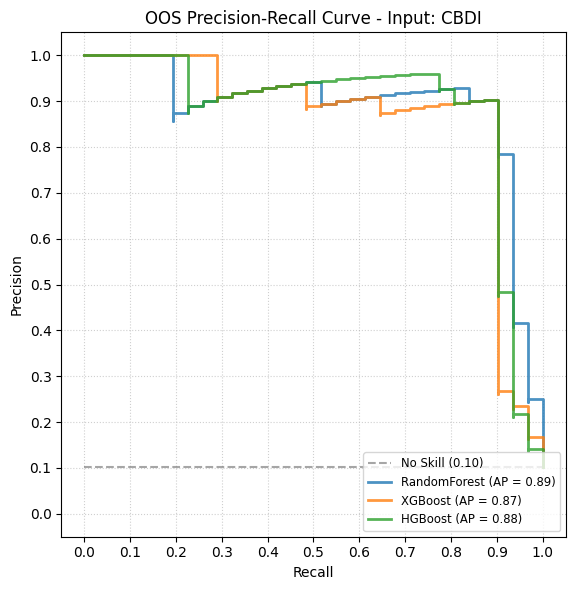


--- Finished Plotting PR Curves ---


In [ ]:
MODEL_COLORS = {
    'Logit': 'red',
    'Logit_L2': 'orange',
    'RandomForest': 'blue',
    'XGBoost': 'green',
    'HGBoost': 'brown'

}
DEFAULT_COLOR = 'grey'


print("\n--- Plotting Out-of-Sample Precision-Recall Curves (One Plot Per Input Set) ---")

# Calculate No-Skill line based on full OOS target prevalence
if len(oos_target) > 0:
    no_skill_level = oos_target.mean()
else:
    no_skill_level = 0.5

for input_name in predictor_sets.keys():
    print(f"\n--- Generating PR Curve Plot for Input Set: {input_name} ---")


    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"OOS Precision-Recall Curve - Input: {input_name}")

    if input_name not in oos_probabilities:
         print(f"  Skipping {input_name}: No probabilities found.")
         plt.close(fig)
         continue

    models_to_plot = oos_probabilities[input_name]
    plot_count = 0


    ax.plot([0, 1], [no_skill_level, no_skill_level], linestyle='--',
            label=f'No Skill ({no_skill_level:.2f})', color='grey', alpha=0.7)


    for model_name, y_proba_list in models_to_plot.items():
        y_proba_raw = np.array(y_proba_list)


        valid_idx_plot = ~np.isnan(y_proba_raw)
        if sum(valid_idx_plot) == 0:
            print(f"  Skipping {model_name}: No valid probabilities.")
            continue

        y_test_eval_plot = oos_target[valid_idx_plot].values
        y_proba_eval_plot = y_proba_raw[valid_idx_plot]


        if len(np.unique(y_test_eval_plot)) <= 1:
            print(f"  Skipping {model_name}: Only one class present in valid OOS target slice.")
            continue

        # Calculate PR AUC to include in label
        try:
             pr_auc = average_precision_score(y_test_eval_plot, y_proba_eval_plot)
             model_label = f'{model_name}'
        except Exception:
             pr_auc = np.nan
             model_label = f'{model_name} (AUC=N/A)'


        # Plot PR curve using from_predictions
        try:
            color = MODEL_COLORS.get(model_name, DEFAULT_COLOR) # Get consistent color
            pr_display = PrecisionRecallDisplay.from_predictions(
                y_test_eval_plot,
                y_proba_eval_plot,
                name=model_label, # Add AUC to the label
                ax=ax,            # Plot on the CURRENT axes      # Use defined color
                lw=2,             # Line width
                alpha=0.8         # Transparency
            )
            plot_count += 1
        except ValueError as ve:
             if "contains only one label" in str(ve):
                 print(f"  Skipping {model_name}: Only one class value present in predictions for plotting (possibly constant probability).")
             else:
                 print(f"  Error plotting PR curve for {model_name}: {ve}")
        except Exception as e:
             print(f"  Error plotting PR curve for {model_name}: {e}")


    # Finalize plot
    if plot_count > 0:
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(loc='lower right', fontsize='small')
    else:
         ax.text(0.5, 0.5, 'No valid data to plot', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    fig_save_path = os.path.join("/content/drive/MyDrive/Diffusion Indices/Visuals/", f'PR_Curve_{input_name}_{prediction_horizon}mo.png')
    plt.savefig(fig_save_path, dpi=300)
    plt.show()

print("\n--- Finished Plotting PR Curves ---")


--- Creating Prediction vs Actual DataFrame ---
 Added predictions/probabilities for HGBoost on CBDI.

Comparison DataFrame (Actual vs Predicted [0.5 Thr] vs Probability):
            Actual  HGBoost_Pred  HGBoost_Proba
1999-04-01     0.0           0.0       0.001869
1999-05-01     0.0           0.0       0.001600
1999-06-01     0.0           0.0       0.001319
1999-07-01     0.0           0.0       0.006705
1999-08-01     0.0           0.0       0.000685
1999-09-01     0.0           0.0       0.002881
1999-10-01     0.0           0.0       0.003658
1999-11-01     0.0           0.0       0.003215
1999-12-01     0.0           0.0       0.005001
2000-01-01     0.0           0.0       0.000094
2000-02-01     0.0           0.0       0.001266
2000-03-01     0.0           0.0       0.007725
2000-04-01     0.0           0.0       0.007030
2000-05-01     0.0           0.0       0.000648
2000-06-01     0.0           0.0       0.000851
2000-07-01     0.0           0.0       0.002359
2000-08-01 

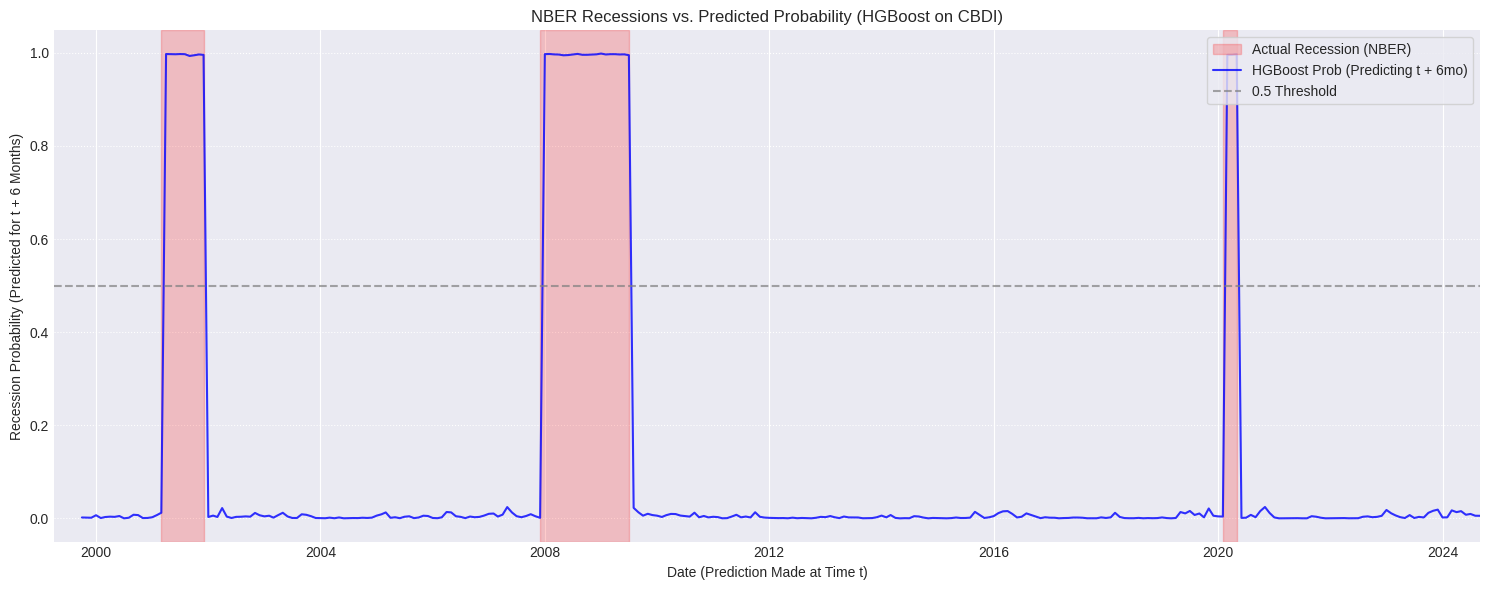

In [ ]:
print("\n--- Creating Prediction vs Actual DataFrame ---")
graph_folder = "/content/drive/MyDrive/Diffusion Indices/Visuals/"

def visualize(chosen_input, chosen_model, aligned=False, save=True):
  comparison_df = pd.DataFrame({'Actual': oos_target})

  if chosen_input in oos_predictions and chosen_model in oos_predictions[chosen_input]:
    pred_list = oos_predictions[chosen_input][chosen_model]
    proba_list = oos_probabilities[chosen_input][chosen_model]


    if len(pred_list) == len(oos_target_indices) and len(proba_list) == len(oos_target_indices):
      comparison_df[f'{chosen_model}_Pred'] = pd.Series(pred_list, index=oos_target_indices)
      comparison_df[f'{chosen_model}_Proba'] = pd.Series(proba_list, index=oos_target_indices)
      print(f" Added predictions/probabilities for {chosen_model} on {chosen_input}.")
    else:
      print(f"WARNING: Length mismatch for {model_name} on {input_name}. Cannot add to comparison.")
      print(f"  Expected length: {len(oos_target_indices)}, Pred length: {len(pred_list)}, Proba length: {len(proba_list)}")


  else:
    print(f"WARNING: Could not find results for Input='{chosen_input}', Model='{chosen_model}'")


  print("\nComparison DataFrame (Actual vs Predicted [0.5 Thr] vs Probability):")
  print(comparison_df.head(20))
  print("...")
  print(comparison_df.tail(20))

  print("\n--- Analyzing Misclassifications ---")
  if f'{chosen_model}_Pred' in comparison_df.columns:
    misclassified = comparison_df[comparison_df['Actual'] != comparison_df[f'{chosen_model}_Pred']]
    false_positives = misclassified[misclassified['Actual'] == 0]
    false_negatives = misclassified[misclassified['Actual'] == 1]

    print(f"\nTotal Misclassified ({chosen_model} on {chosen_input}): {len(misclassified)}")

    print(f"\nFalse Positives (Predicted 1, Actual 0): {len(false_positives)}")
    if not false_positives.empty:
      print(false_positives.sort_index())

    print(f"\nFalse Negatives (Predicted 0, Actual 1): {len(false_negatives)}")
    if not false_negatives.empty:
      print(false_negatives.sort_index())


  print("\\n--- Plotting Predictions Over Time ---")
  if f'{chosen_model}_Proba' in comparison_df.columns:
    fig, ax = plt.subplots(figsize=(15, 6))

    plot_start_date = min(oos_target_indices)
    plot_end_date = max(oos_target_indices)


    y_raw_plot_period = y_raw.loc[plot_start_date : plot_end_date + pd.DateOffset(months=1)] # Ensure we cover the end date

    nber_recession_dates = y_raw_plot_period[y_raw_plot_period == 1].index
    start_shade = None
    first_label = True
    for date in y_raw_plot_period.index:
      is_rec = date in nber_recession_dates
      if is_rec and start_shade is None:
        start_shade = date
      elif not is_rec and start_shade is not None:
        end_shade = date
        ax.axvspan(start_shade, end_shade,
                    color='red', alpha=0.2, label='Actual Recession (NBER)' if first_label else "")
        start_shade = None
        first_label=False
    if start_shade is not None:
      ax.axvspan(start_shade, plot_end_date + pd.DateOffset(months=1), color='red', alpha=0.2, label='Actual Recession (NBER)' if first_label else "")


    if aligned:
      ax.plot(comparison_df.index + pd.DateOffset(months=prediction_horizon), comparison_df[f'{chosen_model}_Proba'], label=f'{chosen_model} Prob (Predicting t + {prediction_horizon}mo)', color='blue', alpha=0.8)
    else:
      ax.plot(comparison_df.index, comparison_df[f'{chosen_model}_Proba'], label=f'{chosen_model} Prob (Predicting t + 3mo)', color='blue', alpha=0.8)


    ax.axhline(0.5, color='grey', linestyle='--', label='0.5 Threshold', alpha=0.7)


    tuned_threshold = results_df_tuned.loc[chosen_input].loc[chosen_model]['Threshold'] # Default if not found



    nber_starts = y_raw_plot_period[(y_raw_plot_period == 1) & (y_raw_plot_period.shift(1) == 0)].index


    if not aligned:
      nber_start_2001 = nber_starts[nber_starts.year == 2001][0]
      pred_peak_date_2001 = comparison_df.loc[:nber_start_2001, f'{chosen_model}_Proba'].idxmax() # Find peak BEFORE start
      pred_peak_val_2001 = comparison_df.loc[pred_peak_date_2001, f'{chosen_model}_Proba']
      if pd.notna(nber_start_2001) and pd.notna(pred_peak_date_2001):
        ax.annotate('Forecast Peak\n(Predicting 3mo Ahead)', xy=(pred_peak_date_2001, pred_peak_val_2001),
                    xytext=(pred_peak_date_2001 - pd.DateOffset(years=1), pred_peak_val_2001 + 0.1),
                    arrowprops=dict(facecolor='green', shrink=0.05, alpha=0.7),
                    fontsize=9, color='green')
        ax.annotate('Actual Start', xy=(nber_start_2001, 0.05), # Point near bottom
                    xytext=(nber_start_2001 + pd.DateOffset(months=6), 0.15),
                    arrowprops=dict(facecolor='red', shrink=0.05, alpha=0.7),
                    fontsize=9, color='red')


    ax.set_ylabel(f'Recession Probability (Predicted for t + {prediction_horizon} Months)')
    ax.set_xlabel('Date (Prediction Made at Time t)') # Clarify axis meaning
    ax.set_title(f'NBER Recessions vs. Predicted Probability ({chosen_model} on {chosen_input})')

    # Adjust legend position if needed
    handles, labels = ax.get_legend_handles_labels()
    # Filter out duplicate labels if NBER span triggered multiple times
    unique_labels = {}
    for handle, label in zip(handles, labels):
      if label not in unique_labels:
        unique_labels[label] = handle
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', frameon=True)


    ax.grid(True, axis='y', linestyle=':')
    ax.set_xlim(plot_start_date, plot_end_date) # Ensure plot range matches evaluation

    plt.tight_layout()
    if save:
      if aligned:
        plt.savefig(f'{graph_folder}{chosen_model}_{chosen_input}_{prediction_horizon}mo_aligned.png')
      else:
        plt.savefig(f'{graph_folder}{chosen_model}_{chosen_input}_{prediction_horizon}mo.png')
    plt.show()


  else:
      print("Could not plot - probabilities not found.")

# for input in ['Factors', 'CBDI', 'Full', 'FBDI', 'FBDI_Recursive', 'Yield']:
#   for model in ['Logit', 'Logit_L2', 'RandomForest', 'XGBoost', 'HGBoost']:
visualize('CBDI', 'HGBoost', aligned=True, save=False)


In [ ]:
results_df_tuned

Threshold  PR AUC  ROC AUC  Recall (1)  Precision (1)  \
Input Model                                                                 
CBDI  RandomForest     0.6111  0.8885   0.9790      0.9032         0.9032   
      XGBoost          0.9255  0.8657   0.9564      0.9032         0.9032   
      HGBoost          0.9932  0.8829   0.9582      0.9032         0.9032   

                    F1 (1)  Num Forecasts  
Input Model                                
CBDI  RandomForest  0.9032            306  
      XGBoost       0.9032            306  
      HGBoost       0.9032            306

In [ ]:
all_metrics_df = pd.DataFrame(all_metrics_list)

--- Preparing data for bar chart ---
Input Sets to Plot: ['CBDI']
Models to Plot: ['RandomForest', 'XGBoost', 'HGBoost']

Prepared DataFrame for plotting (first few rows):
  Input Set         Model  PR AUC  Plot Group
0      CBDI  RandomForest  0.8885           1
1      CBDI       XGBoost  0.8657           1
2      CBDI       HGBoost  0.8829           1

--- Generating Bar Charts (Split) ---

 Generating Plot 1...
 Saved Bar Chart Plot 1 to: /content/drive/MyDrive/Diffusion Indices/Visuals/PR_AUC_Comparison_BarChart_Plot1_CBDI_h6.png


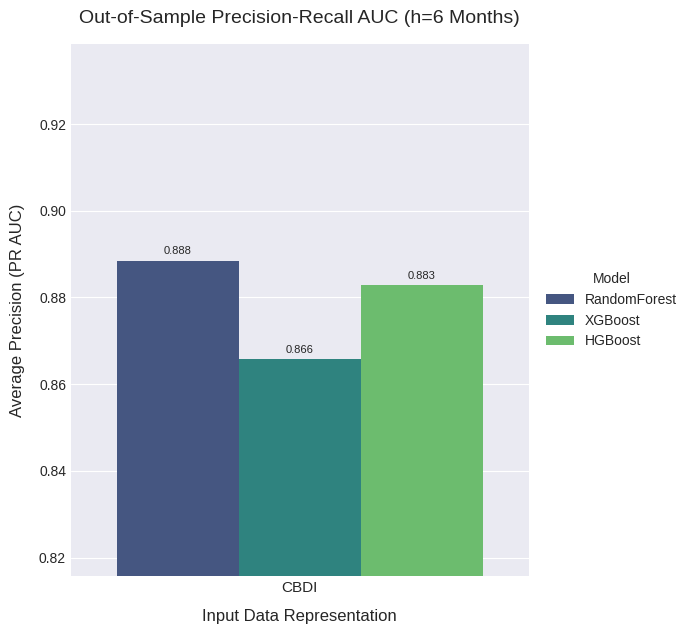


 Generating Plot 2...
 No data for Plot 2. Skipping.


In [ ]:
print("--- Preparing data for bar chart ---")
plot_data = []

input_order_plot1 = ['CBDI']
model_order = ['RandomForest', 'XGBoost', 'HGBoost']
all_inputs_ordered = input_order_plot1


models_present = set()
for input_name in all_inputs_ordered:
    if input_name in results_df_rec.index.get_level_values(0):
        models_present.update(results_df_rec.loc[input_name].index)

print(f"Input Sets to Plot: {all_inputs_ordered}")
print(f"Models to Plot: {model_order}")

# Extract data
for input_name in all_inputs_ordered:
     if input_name in results_df_rec.index.get_level_values(0):
         for model_name in model_order:

             pr_auc = results_df_rec.loc[input_name].loc[model_name]['PR AUC']
             plot_group = 1 if input_name in input_order_plot1 else 2
             plot_data.append({'Input Set': input_name,
                               'Model': model_name,
                               'PR AUC': pr_auc,
                               'Plot Group': plot_group})

# Convert to DataFrame
plot_df_full = pd.DataFrame(plot_data)
plot_df_full.dropna(subset=['PR AUC'], inplace=True) # Drop if metric is missing

# Ensure categorical order for plots
plot_df_full['Input Set'] = pd.Categorical(plot_df_full['Input Set'], categories=all_inputs_ordered, ordered=True)
plot_df_full['Model'] = pd.Categorical(plot_df_full['Model'], categories=model_order, ordered=True)

print("\nPrepared DataFrame for plotting (first few rows):")
print(plot_df_full.head())


print("\n--- Generating Bar Charts (Split) ---")
plt.style.use('seaborn-v0_8-darkgrid')
num_models_plot = len(plot_df_full['Model'].unique())
try:
    if num_models_plot <= 10: palette_name = 'viridis' # Viridis often good contrast
    elif num_models_plot <= 20: palette_name = 'tab20'
    else: palette_name = 'viridis'
    palette = sns.color_palette(palette_name, n_colors=num_models_plot)
except Exception as e:
    palette = sns.color_palette(n_colors=num_models_plot)


for plot_num in [1, 2]:
    print(f"\n Generating Plot {plot_num}...")
    plot_df_subset = plot_df_full[plot_df_full['Plot Group'] == plot_num].copy()

    if plot_df_subset.empty:
         print(f" No data for Plot {plot_num}. Skipping.")
         continue

    input_sets_in_plot = plot_df_subset['Input Set'].unique().tolist()


    fig_width = max(8, 2.5 * len(input_sets_in_plot))
    fig, ax = plt.subplots(figsize=(fig_width, 7))


    barplot = sns.barplot(x='Input Set', y='PR AUC', hue='Model',
                          data=plot_df_subset, palette=palette, ax=ax, errorbar=None)


    for container in ax.containers:
        try:
             ax.bar_label(container, fmt='%.3f', fontsize=8, padding=3, rotation=0)
        except Exception as e:
             print(f" Warning: Could not add bar labels - {e}")



    ax.set_title(f'Out-of-Sample Precision-Recall AUC (h={prediction_horizon} Months)', fontsize=14, pad=15)
    ax.set_xlabel('Input Data Representation', fontsize=12, labelpad=10)
    ax.set_ylabel('Average Precision (PR AUC)', fontsize=12, labelpad=10)
    ax.tick_params(axis='x', rotation=0, labelsize=11)
    ax.tick_params(axis='y', labelsize=10)


    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize='medium', title='Model')


    min_auc = max(0, plot_df_subset['PR AUC'].min() - 0.05)
    max_auc = min(1, plot_df_subset['PR AUC'].max() + 0.05)
    if max_auc - min_auc < 0.1:
         min_auc = max(0, min_auc - 0.05)
         max_auc = min(1, max_auc + 0.05)
    ax.set_ylim(min_auc, max_auc)

    plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])


    graph_folder = '/content/drive/MyDrive/Diffusion Indices/Visuals/'
    os.makedirs(graph_folder, exist_ok=True)
    save_path = os.path.join(graph_folder, f'PR_AUC_Comparison_BarChart_Plot{plot_num}_CBDI_h{prediction_horizon}.png')
    try:
        plt.savefig(save_path, dpi=500)
        print(f" Saved Bar Chart Plot {plot_num} to: {save_path}")
    except Exception as e:
         print(f" ERROR saving Bar Chart Plot {plot_num}: {e}")

    plt.show()

In [ ]:
models_for_avg = ['Logit', 'Logit_L2']
metrics_to_avg = ['PR AUC']


filtered_results = results_df_rec[results_df_rec.index.get_level_values('Model').isin(models_for_avg)]


avg_performance = filtered_results.groupby(level='Input')[metrics_to_avg].mean().round(3)
avg_performance = avg_performance.sort_values(by='PR AUC', ascending=False)

print("\\n--- Average Performance Across Top Models ---")
avg_performance

In [ ]:
METRIC_TO_PLOT_HM = 'PR AUC'
PLOT_TITLE_HM = f'Model Performance Heatmap ({METRIC_TO_PLOT_HM})'

if METRIC_TO_PLOT_HM not in results_df_tuned.columns:
  print(f"ERROR: Metric '{METRIC_TO_PLOT_HM}' not found in results DataFrame columns.")
  exit()


try:
  heatmap_data = results_df_tuned[METRIC_TO_PLOT_HM].unstack(level='Model')
  model_order = ['Logit', 'Logit_L2', 'RandomForest', 'XGBoost', 'HGBoost']
  input_order = ['Yield', 'Factors', 'Full', 'CBDI', 'FBDI', 'FBDI_Recursive']
  models_present = [m for m in model_order if m in heatmap_data.columns]
  inputs_present = [i for i in input_order if i in heatmap_data.index]
  heatmap_data = heatmap_data.loc[inputs_present, models_present]
  print("\nPivoted DataFrame for Heatmap:")
  print(heatmap_data)
except KeyError as e:
  print(f"ERROR unstacking DataFrame, potentially missing combinations or incorrect index levels: {e}")
  exit()
except Exception as e:
  print(f"Error preparing heatmap data: {e}")
  exit()

if heatmap_data.empty:
  print("ERROR: No data available for heatmap after pivoting/filtering.")
  exit()

print("\n--- Generating Heatmap ---")


num_rows = len(heatmap_data.index)
num_cols = len(heatmap_data.columns)
fig_width = max(8, 1.5 * num_cols)
fig_height = max(6, 0.8 * num_rows)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

cmap_heatmap = "viridis"

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    linewidths=.5,
    cmap=cmap_heatmap,
    ax=ax,
    cbar_kws={'label': METRIC_TO_PLOT_HM},
    annot_kws={"size": 9}
)


ax.set_title(PLOT_TITLE_HM, fontsize=14, pad=15)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Input Data Representation', fontsize=12)
ax.tick_params(axis='x', labelsize=10, rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=10, rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.97])


graph_folder = '/content/drive/MyDrive/Diffusion Indices/Visuals/'
os.makedirs(graph_folder, exist_ok=True)
save_path = os.path.join(graph_folder, f'{METRIC_TO_PLOT_HM.replace(" ","")}_Comparison_Heatmap_h{prediction_horizon}.png')
try:
  # plt.savefig(save_path, dpi=150, bbox_inches='tight')
  print(f"\nSaved Heatmap to: {save_path}")
except Exception as e:
    print(f"\nERROR saving Heatmap: {e}")

plt.show()